# Sales forcasting

### Introduction
Our Main Objective is to predict sales of store in a week. As in dataset size and time related data are given as feature, so analyze if sales are impacted by time-based factors and space- based factor. Most importantly how inclusion of holidays in a week soars the sales in store?

In [89]:
# Import libraries
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot as auto_corr

# To plot
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

#For date-time
import math
from datetime import datetime
from datetime import timedelta

import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima


import warnings
warnings.filterwarnings("ignore")

from IPython.display import Image

Download data from https://www.kaggle.com/code/aslanahmedov/walmart-sales-forecasting/notebook

Analysis with the help of https://www.kaggle.com/code/aslanahmedov/walmart-sales-forecasting/notebook

#### Background
Walmart is a renowned retail corporation that operates a chain of hypermarkets. Here, Walmart has provided a data combining of 45 stores including store information and monthly sales. The data is provided on weekly basis. Walmart tries to find the impact of holidays on the sales of store. For which it has included four holidays’ weeks into the dataset which are Christmas, Thanksgiving, Super bowl, Labor Day. Here we are owing to Analyze the dataset given.

In [90]:
pd.options.display.max_columns=100

In [91]:
df_store = pd.read_csv('/Users/moni/DS - Karan/Week5/Data-3/stores.csv')
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [92]:
df_train = pd.read_csv('/Users/moni/DS - Karan/Week5/Data-3/train.csv')
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [93]:
df_features = pd.read_csv('/Users/moni/DS - Karan/Week5/Data-3/features.csv') 
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [94]:
# merging 3 different sets
df = df_train.merge(df_features, on=['Store', 'Date'], how='inner').merge(df_store, on=['Store'], how='inner')
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


## Data cleaning and pre-processing

In [95]:
df.drop(['IsHoliday_y'], axis=1,inplace=True) # removing dublicated column

In [96]:
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True) # rename the column
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [97]:
df.shape

(421570, 16)

In [98]:
# Number of Stores and departments
print(f"Number of Stores: {df['Store'].nunique()}")
print(f"Number of Stores: {df['Dept'].nunique()}")

Number of Stores: 45
Number of Stores: 81


In [99]:
# Average weekly sales for each store and each department
store_dept_table = pd.pivot_table(df, index='Store', columns='Dept',
                                  values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,55,56,58,59,60,65,67,71,72,74,77,78,79,80,81,82,83,85,87,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,24919.270629,10566.545315,38692.880490,15268.550909,24151.061329,9196.557902,7765.304425,1259.018531,4091.571538,7808.450559,8052.076154,21623.184685,6187.389720,10152.336783,6767.997273,1374.649650,593.113986,4651.040210,3415.295035,2408.533287,8202.668392,5946.431189,11530.831678,2535.730909,1476.203566,2800.495105,79978.222587,NaN,58510.409161,1064.769650,7940.326224,NaN,4872.724406,23.995070,19662.989860,-116.454545,917.727920,11437.931259,NaN,32.712727,2355.439371,90.921053,12817.843357,4000.480629,3372.474476,857.775105,1020.995804,NaN,7436.017343,2732.473357,47390.644895,11652.827413,677.000000,11.500000,33974.792937,17139.314615,29780.696573,20727.860909,5704.048951,3685.875524,46006.277203,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,23382.686154,7735.946294,46117.959231,21314.132937,27005.179650,13790.854196,11687.563009,4053.439930,5748.619441,9910.939860,12923.013846,29170.616573,8309.564545,15299.508392,9347.725105,1837.954615,798.913217,7111.482657,4981.155385,3884.756993,11755.096713,7488.096993,17595.203497,3875.588601,2631.750559,4500.250769,85114.996014,2.340000,78174.560210,2592.220769,8768.857692,NaN,7245.541189,29.139848,29675.324545,18.068182,1358.347914,15568.465664,NaN,16.226667,4148.373566,104.502868,13060.297692,5545.122308,21610.019091,1391.520559,221.545946,NaN,12125.255594,4634.609371,72929.496643,16986.406014,817.500000,11.764000,32759.096993,26041.273566,31000.484266,24647.232587,5710.719650,3672.042797,24932.985804,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,8774.928042,2383.603007,11363.061678,4626.649021,7871.568322,2634.199650,2960.677739,731.313147,1682.199231,1244.529650,3101.769860,10913.330070,2763.627343,4260.447972,2850.050839,500.193636,166.870070,1517.404056,1243.926993,878.475455,4296.111049,3228.155105,4579.719161,1439.325524,622.689371,NaN,108598.364126,NaN,18203.108252,646.832028,4422.944406,NaN,2133.657762,9.922500,6179.259510,38.875000,NaN,17.581481,NaN,5.411803,961.390210,58.311239,7153.737902,1606.808881,NaN,244.878455,138.125874,NaN,2021.482657,1101.610000,22796.856573,3374.960769,424.000000,6.000000,7230.372448,24.420476,1429.300070,6746.578392,19.330000,874.128182,939.435455,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,27145.836643,8141.910979,69596.447343,28567.509441,21270.153007,15815.878042,13146.543790,3038.317762,8888.302867,8865.273147,17289.916294,46234.012867,10875.301189,15640.748531,18429.759930,2579.906154,916.232238,9472.121189,7683.686783,3813.243986,13685.430350,12304.056224,25142.675385,4376.574755,3005.231469,3640.752727,80093.946084,1.560000,78729.263077,975.417622,9511.818531,NaN,5441.563566,13.696939,39128.896154,23.536154,2324.615532,6911.676643,NaN,8.200000,3721.521329,131.887000,18662.627203,6040.540839,6078.142308,1586.446993,410.795105,NaN,12471.426713,7686.018741,101244.450839,20627.307762,344.571429,5.375000,52436.656923,19379.101399,31055.285315,29371.320979,9161.217343,2730.060000,14223.462308,8

Looking at the pivot table, it's clear that there are incorrect values—some are 0 or even negative for weekly sales. Sales amounts can't be negative, and it's unlikely for a department to have zero sales for an entire week. Therefore, I'll fix these values.

In [100]:
df.loc[df['Weekly_Sales']<=0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
188,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
406,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
2549,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315
3632,1,54,2011-01-21,-50.00,False,44.04,3.016,NaN,NaN,NaN,NaN,NaN,211.827234,7.742,A,151315
4132,1,47,2011-03-11,0.00,False,53.56,3.459,NaN,NaN,NaN,NaN,NaN,214.111056,7.742,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420066,45,49,2012-05-25,-4.97,False,67.21,3.798,5370.39,NaN,361.22,1287.62,2461.81,191.002810,8.567,B,118221
420403,45,49,2012-06-29,-34.00,False,75.22,3.506,3291.36,425.60,NaN,314.88,2255.34,191.099246,8.567,B,118221
420736,45,49,2012-08-03,-1.91,False,76.58,3.654,24853.05,39.56,17.96,11142.69,2768.32,191.164090,8.684,B,118221
421007,45,54,2012-08-31,0.00,False,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,191.461281,8.684,B,118221


In [101]:
print(f"The percentage of zero and negative values is: {(1358 / 421570) * 100}%")

The percentage of zero and negative values is: 0.3221291837654482%


1358 rows in 421570 rows means 0.3%, so I can delete and ignore these rows which contains wrong sales values.

In [102]:
df = df.loc[df['Weekly_Sales'] > 0]
df.shape

(420212, 16)

In [103]:
# Date
# Find the minimum and maximum dates
min_date = df['Date'].min()
max_date = df['Date'].max()

print(f"Minimum Date: {min_date}")
print(f"Maximum Date: {max_date}")

Minimum Date: 2010-02-05
Maximum Date: 2012-10-26


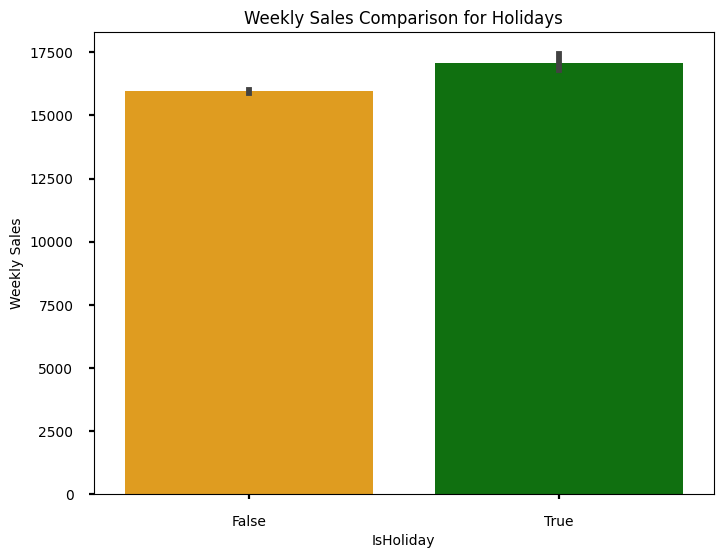

In [189]:
# IsHoliday
plt.figure(figsize=(8, 6))
colors = {'True': 'green', 'False': 'orange'}
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df, palette=colors)
plt.title('Weekly Sales Comparison for Holidays', fontsize=12)
plt.xlabel('IsHoliday', fontsize=10)  
plt.ylabel('Weekly Sales', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [105]:
df_holiday = df.loc[df['IsHoliday']==True]
df_holiday['Date'].unique() 

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [106]:
df_not_holiday = df.loc[df['IsHoliday']==False]
df_not_holiday['Date'].nunique() 

133

All holidays are not in the data. There are 4 holiday values such as;

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13

Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13

Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13

Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

After the 07-Sep-2012 holidays are in test set for prediction. When we look at the data, average weekly sales for holidays are significantly higher than not-holiday days. In train data, there are 133 weeks for non-holiday and 10 weeks for holiday.

I want to see differences between holiday types. So, I create new columns for 4 types of holidays and fill them with boolean values. If date belongs to this type of holiday it is True, if not False.

In [107]:
# Super bowl dates in train set
df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10'),'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12')&(df['Date'] != '2011-02-11')&(df['Date'] != '2012-02-10'),'Super_Bowl'] = False
# Labor day dates in train set
df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&(df['Date'] != '2012-09-07'),'Labor_Day'] = False
# Thanksgiving dates in train set
df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25'),'Thanksgiving'] = False
#Christmas dates in train set
df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

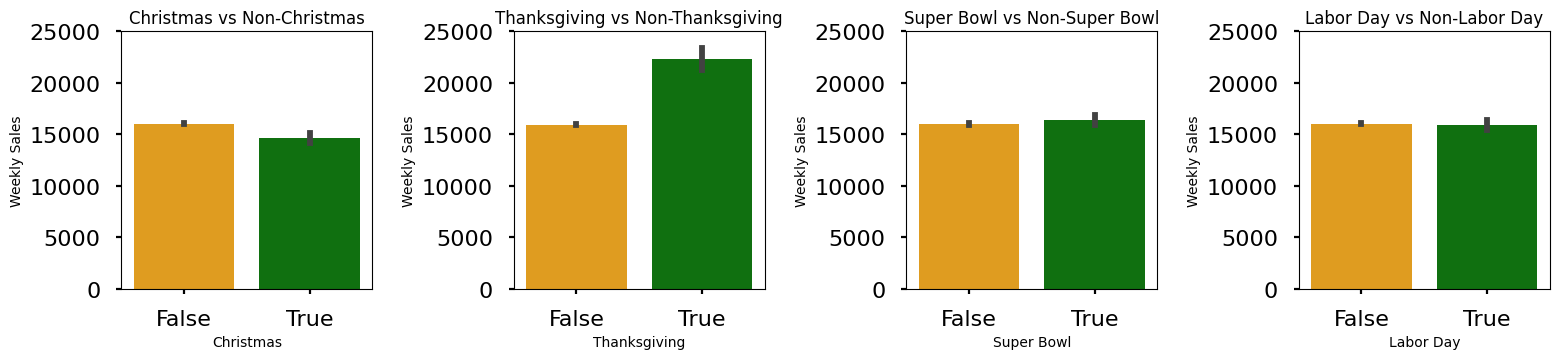

In [192]:
# Set up the subplots
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Define colors for True and False
colors = {'True': 'green', 'False': 'orange'}

# Plot for Christmas
sns.barplot(x='Christmas', y='Weekly_Sales', data=df, palette=colors, ax=axes[0])
axes[0].set_title('Christmas vs Non-Christmas', fontsize=12)
axes[0].set_xlabel('Christmas', fontsize=10)
axes[0].set_ylabel('Weekly Sales', fontsize=10)
axes[0].set_ylim(0 , 25000)  # Set y-axis limits

# Plot for Thanksgiving
sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=df, palette=colors, ax=axes[1])
axes[1].set_title('Thanksgiving vs Non-Thanksgiving', fontsize=12)
axes[1].set_xlabel('Thanksgiving', fontsize=10)
axes[1].set_ylabel('Weekly Sales', fontsize=10)
axes[1].set_ylim(0 , 25000)

# Plot for Super Bowl
sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=df, palette=colors, ax=axes[2])
axes[2].set_title('Super Bowl vs Non-Super Bowl', fontsize=12)
axes[2].set_xlabel('Super Bowl', fontsize=10)
axes[2].set_ylabel('Weekly Sales', fontsize=10)
axes[2].set_ylim(0 , 25000)

# Plot for Labor Day
sns.barplot(x='Labor_Day', y='Weekly_Sales', data=df, palette=colors, ax=axes[3])
axes[3].set_title('Labor Day vs Non-Labor Day', fontsize=12)
axes[3].set_xlabel('Labor Day', fontsize=10)
axes[3].set_ylabel('Weekly Sales', fontsize=10)
axes[3].set_ylim(0 , 25000)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


The graphs reveal that Labor Day and Christmas don't boost the weekly average sales. Super Bowl shows a positive impact, but the most significant difference is seen during Thanksgiving. My hunch is that people tend to purchase Christmas gifts 1-2 weeks before Christmas, so such customer behavior is causing a negative sale in the week of Christmas. Additionally, Black Friday sales likely contribute to the spike in Thanksgiving week.

In [109]:
# Type Effect on Holidays
# There are three different store types in the data as A, B and C.
df.groupby(['Christmas','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Christmas 

Christmas  Type
False      A       20174.350209
           B       12301.986116
           C        9570.951973
True       A       18310.167535
           B       11488.988057
           C        8031.520607
Name: Weekly_Sales, dtype: float64

#### What are types A, B & C: 
The store sizes align with sales as anticipated. Bigger stores tend to have higher sales, and Walmart categorizes stores by size. Type A starts with the smallest size values, followed by Type B after reaching its smallest size, and then Type C.

In [110]:
df.groupby(['Labor_Day','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Labor Day

Labor_Day  Type
False      A       20151.210941
           B       12294.954138
           C        9542.098293
True       A       20004.267422
           B       12084.304642
           C        9893.459258
Name: Weekly_Sales, dtype: float64

In [111]:
df.groupby(['Thanksgiving','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Thanksgiving

Thanksgiving  Type
False         A       20044.007801
              B       12197.717405
              C        9547.377807
True          A       27397.776346
              B       18733.973971
              C        9696.566616
Name: Weekly_Sales, dtype: float64

In [112]:
df.groupby(['Super_Bowl','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Super Bowl

Super_Bowl  Type
False       A       20138.055908
            B       12286.739293
            C        9536.110508
True        A       20612.757674
            B       12467.035506
            C       10179.271884
Name: Weekly_Sales, dtype: float64

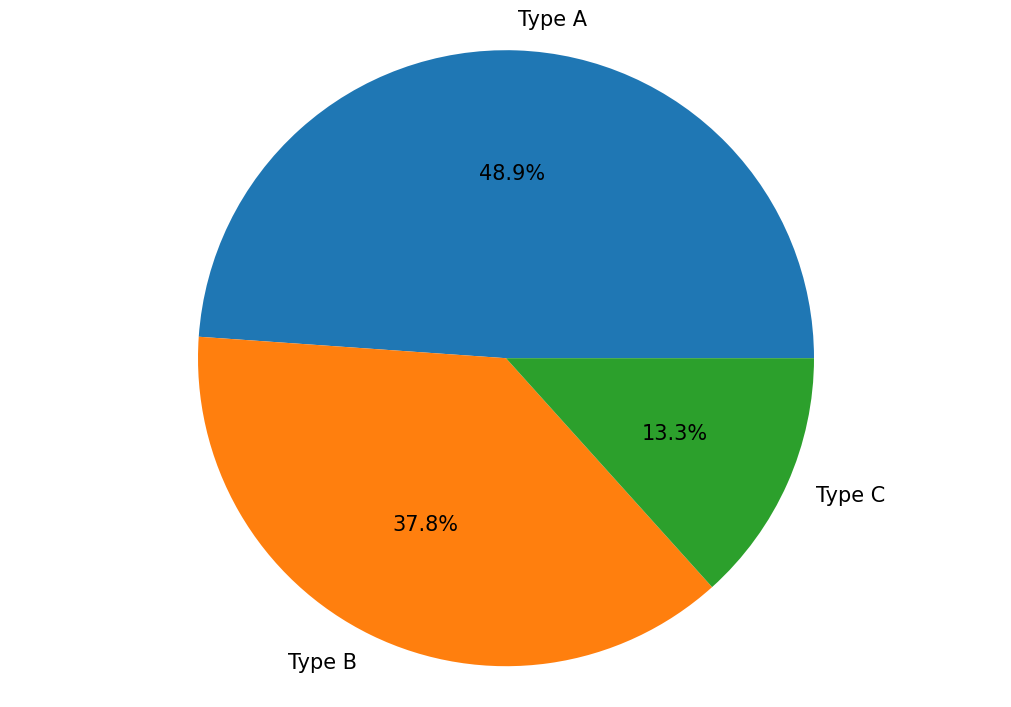

In [193]:
my_data = [48.88, 37.77 , 13.33 ]  #percentages
my_labels = 'Type A','Type B', 'Type C' # labels
plt.pie(my_data,labels=my_labels, autopct='%1.1f%%', textprops={'fontsize': 15})
plt.axis('equal')
mpl.rcParams.update({'font.size': 20})

plt.show()


In [114]:
df.groupby('IsHoliday')['Weekly_Sales'].mean()

IsHoliday
False    15952.816352
True     17094.300918
Name: Weekly_Sales, dtype: float64

Approximately half of the stores fall into Type A category. This distribution highlights the prevalence and significance of Type A stores within the ecommerce landscape.

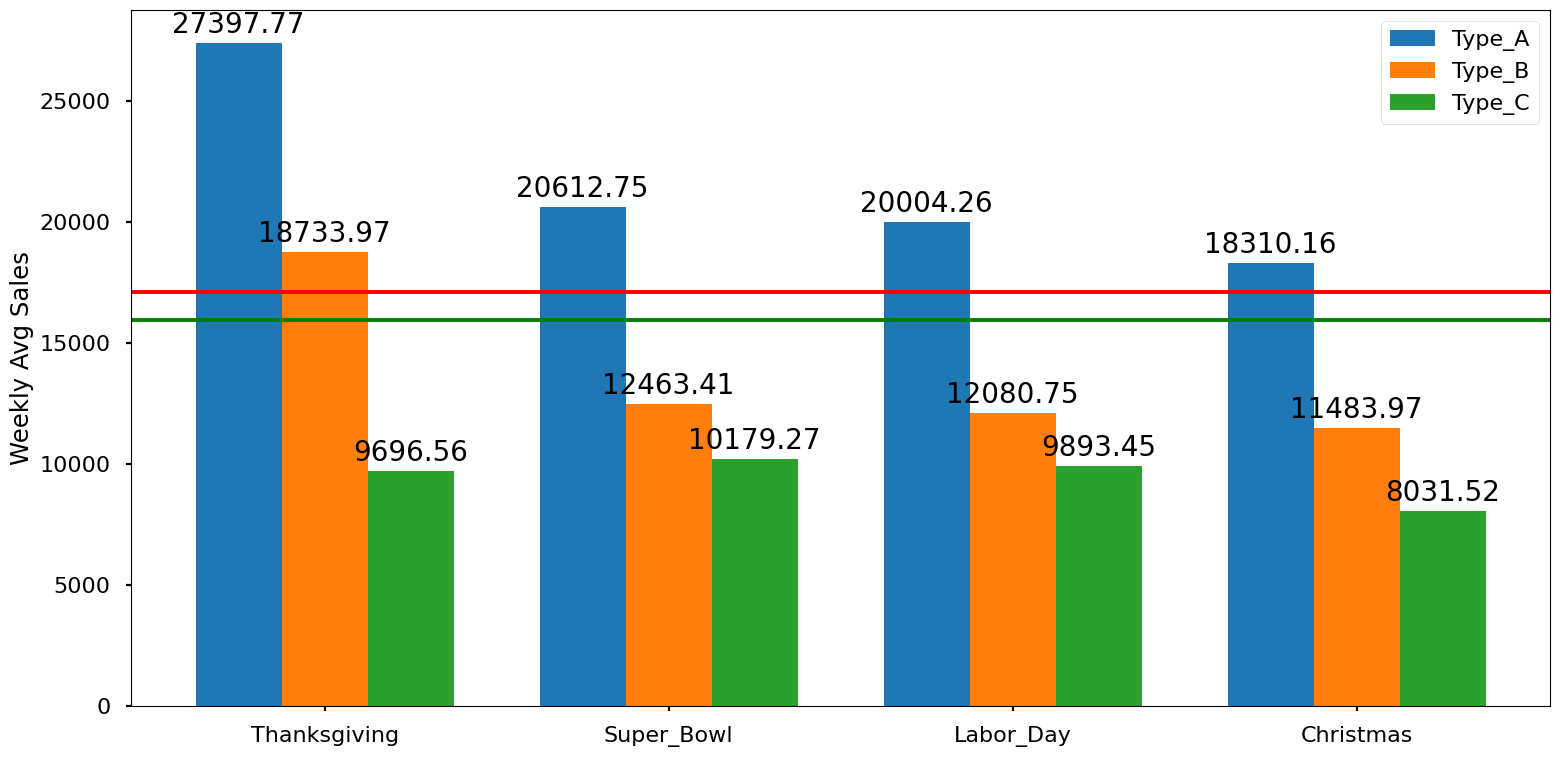

In [115]:
# Plotting avg wekkly sales according to holidays by types
plt.style.use('seaborn-poster')
labels = ['Thanksgiving', 'Super_Bowl', 'Labor_Day', 'Christmas']
A_means = [27397.77, 20612.75, 20004.26, 18310.16]
B_means = [18733.97, 12463.41, 12080.75, 11483.97]
C_means = [9696.56,10179.27,9893.45,8031.52]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width, A_means, width, label='Type_A')
rects2 = ax.bar(x , B_means, width, label='Type_B')
rects3 = ax.bar(x + width, C_means, width, label='Type_C')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Weekly Avg Sales')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.axhline(y=17094.30,color='r') # holidays avg
plt.axhline(y=15952.82,color='green') # not-holiday avg

fig.tight_layout()

plt.show()

The graph clearly illustrates that the peak in average sales occurs during the Thanksgiving week among the holidays. Moreover, across all holidays, Type A stores consistently demonstrate the highest sales, underscoring their substantial impact on overall sales performance.

In [116]:
df.sort_values(by='Weekly_Sales',ascending=False).head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas
90645,10,72,2010-11-26,693099.36,True,55.33,3.162,NaN,NaN,NaN,NaN,NaN,126.669267,9.003,B,126512,False,False,True,False
337053,35,72,2011-11-25,649770.18,True,47.88,3.492,1333.24,NaN,58563.24,20.97,6386.86,140.421786,8.745,B,103681,False,False,True,False
94393,10,72,2011-11-25,630999.19,True,60.68,3.760,174.72,329.0,141630.61,79.00,1009.98,129.836400,7.874,B,126512,False,False,True,False
333594,35,72,2010-11-26,627962.93,True,46.67,3.039,NaN,NaN,NaN,NaN,NaN,136.689571,8.763,B,103681,False,False,True,False
131088,14,72,2010-11-26,474330.10,True,46.15,3.039,NaN,NaN,NaN,NaN,NaN,182.783277,8.724,A,200898,False,False,True,False


Also, it is not surprise that top 5 highest weekly sales are belongs to Thanksgiving weeks.

In [117]:
# See the Size-Type relation
df_store.groupby('Type').describe()['Size'].round(2)

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,22.0,177247.73,49392.62,39690.0,155840.75,202406.0,203819.0,219622.0
B,17.0,101190.71,32371.14,34875.0,93188.00,114533.0,123737.0,140167.0
C,6.0,40541.67,1304.15,39690.0,39745.00,39910.0,40774.0,42988.0


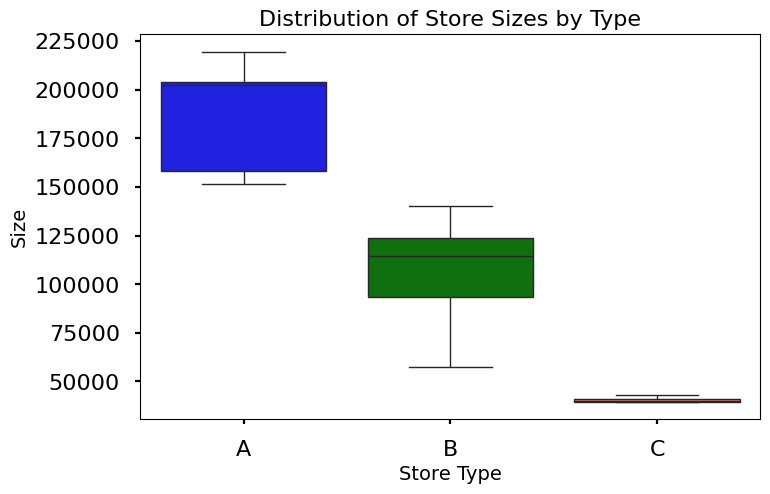

In [118]:
# Set a custom color palette
custom_palette = {'A': 'blue', 'B': 'green', 'C': 'coral'}
plt.figure(figsize=(8, 5))
# Use a boxen plot for better visualization of the data distribution
fig = sns.boxplot(x='Type', y='Size', data=df, palette=custom_palette, showfliers=False)
# Enhance the plot with labels and title
plt.xlabel('Store Type', fontsize=14)
plt.ylabel('Size', fontsize=14)
plt.title('Distribution of Store Sizes by Type', fontsize=16)
plt.grid(False)
# Display the plot
plt.show()

The store sizes align with sales as anticipated. Bigger stores tend to have higher sales, and Walmart categorizes stores by size, as shown in the graph. Type A starts with the smallest size values, followed by Type B after reaching its smallest size, and then Type C.

In [119]:
# Markdown Columns
# When I check columns, there are many NaN values for markdowns. I decided to change them with 0, 
# because if there is markdown in the row, it is shown with numbres. 
# So, if I can write 0, it shows there is no markdown at that date.
df.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270031
MarkDown2       309308
MarkDown3       283561
MarkDown4       285694
MarkDown5       269283
CPI                  0
Unemployment         0
Type                 0
Size                 0
Super_Bowl           0
Labor_Day            0
Thanksgiving         0
Christmas            0
dtype: int64

In [120]:
df = df.fillna(0)
df.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Super_Bowl      0
Labor_Day       0
Thanksgiving    0
Christmas       0
dtype: int64

In [121]:
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591,60.090599,3.360890,2590.323565,878.905242,468.845949,1083.534361,1662.805002,171.212496,7.960000,136749.732787
std,12.787236,30.508819,22729.492116,18.447857,0.458519,6053.415601,5076.928566,5534.069859,3896.068938,4206.209357,39.162445,1.863879,60993.084568
min,1.000000,1.000000,0.010000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2120.130000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7661.700000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,20271.265000,74.280000,3.738000,2809.050000,2.400000,4.540000,425.290000,2168.040000,212.445487,8.567000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


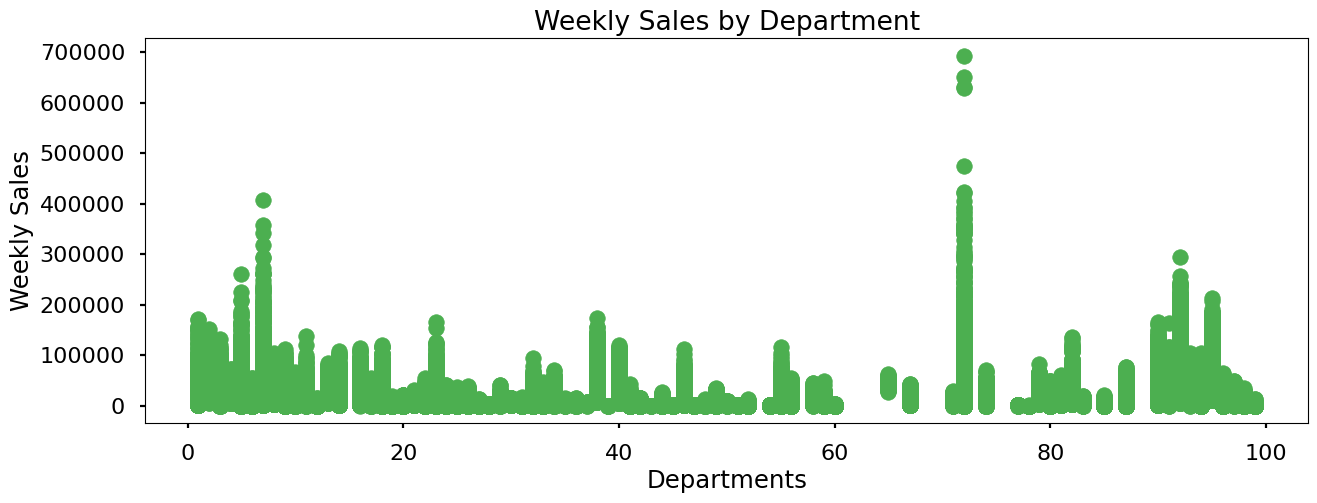

In [122]:
# Weekly sale by department
x = df['Dept']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Department')
plt.xlabel('Departments')
plt.ylabel('Weekly Sales')
plt.scatter(x,y, color='#4CAF50')
plt.grid(False)
plt.show()

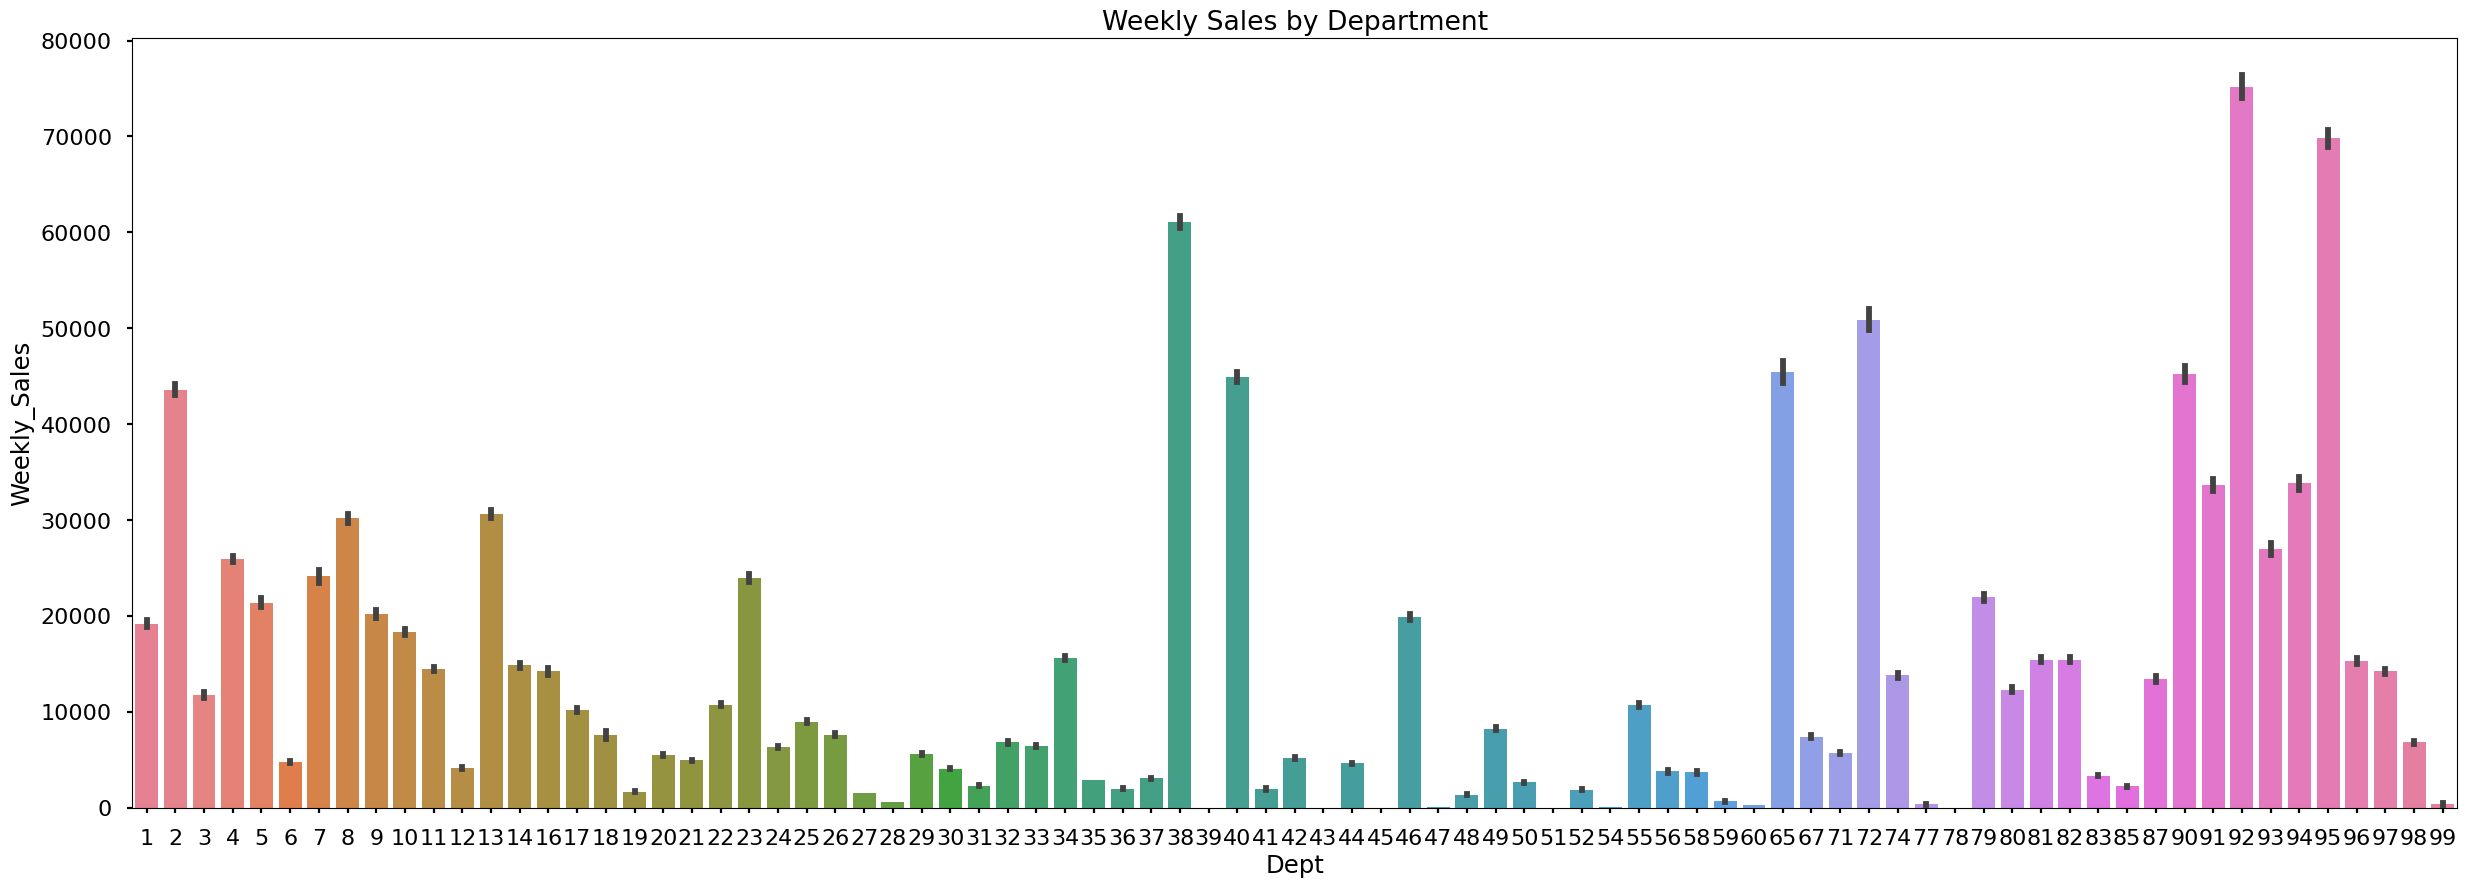

In [123]:
plt.figure(figsize=(30,10))
custom_palette = sns.color_palette("husl", n_colors=len(df['Dept'].unique()))
fig = sns.barplot(x='Dept', y='Weekly_Sales', data=df, palette=custom_palette)
plt.grid(False)
plt.title('Weekly Sales by Department')
plt.show()

From the first graph, it is seen that one department between 60-80(I assume it is 72), has higher sales values. But, when we take the averages, it is seen that department 92 has higher mean sales. Department 72 is seasonal department, I think. It has higher values is some seasons but on average 92 is higher.

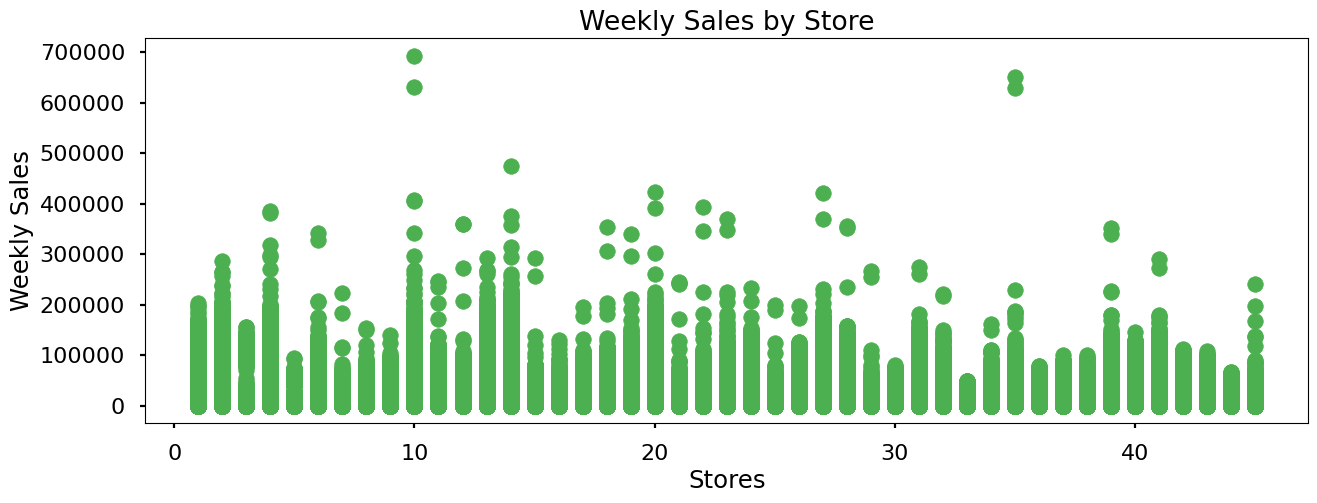

In [124]:
# Weekly Sales by Store
x = df['Store']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Store')
plt.xlabel('Stores')
plt.ylabel('Weekly Sales')
plt.scatter(x,y, color='#4CAF50')
plt.grid(False)
plt.show()

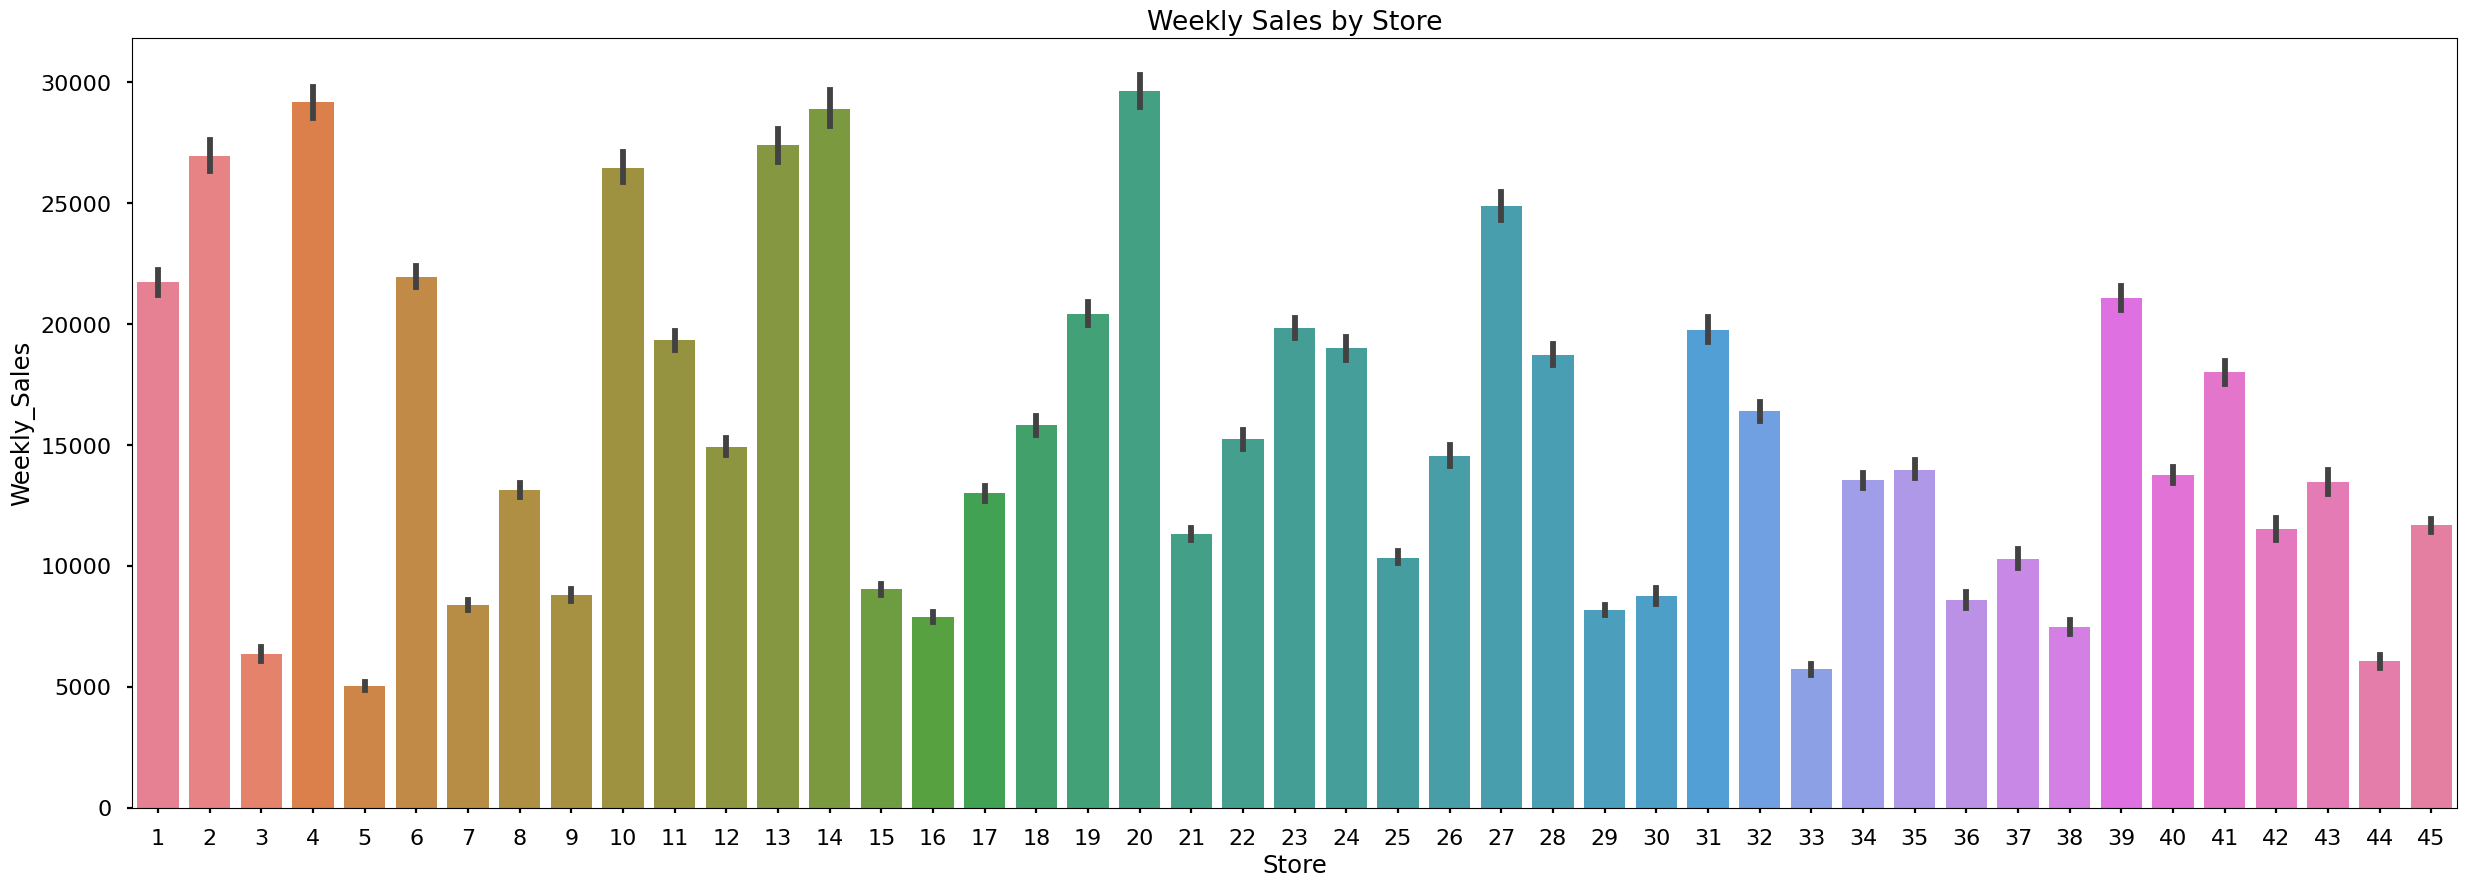

In [125]:
plt.figure(figsize=(30,10))
custom_palette = sns.color_palette("husl", n_colors=len(df['Store'].unique()))
fig = sns.barplot(x='Store', y='Weekly_Sales', data=df, palette=custom_palette)
plt.grid(False)
plt.title('Weekly Sales by Store')
plt.show()

Same thing happens in stores. From the first graph, some stores has higher sales but on average store 20 is the best and 4 and 14 following it.

In [126]:
# Changing Date to Datetime and Creating New Columns
df["Date"] = pd.to_datetime(df["Date"]) # convert to datetime
df['week'] = df['Date'].dt.isocalendar().week
df['month'] =df['Date'].dt.month 
df['year'] =df['Date'].dt.year
df.groupby('month')['Weekly_Sales'].mean()

month
1     14182.239153
2     16048.701191
3     15464.817698
4     15696.435193
5     15845.556200
6     16397.605478
7     15905.472425
8     16113.800069
9     15147.216063
10    15279.182119
11    17534.964277
12    19425.798603
Name: Weekly_Sales, dtype: float64

In [127]:
df.groupby('year')['Weekly_Sales'].mean() # to see the best years for sales

year
2010    16318.648285
2011    16007.797985
2012    15748.265005
Name: Weekly_Sales, dtype: float64

<Figure size 1500x500 with 0 Axes>

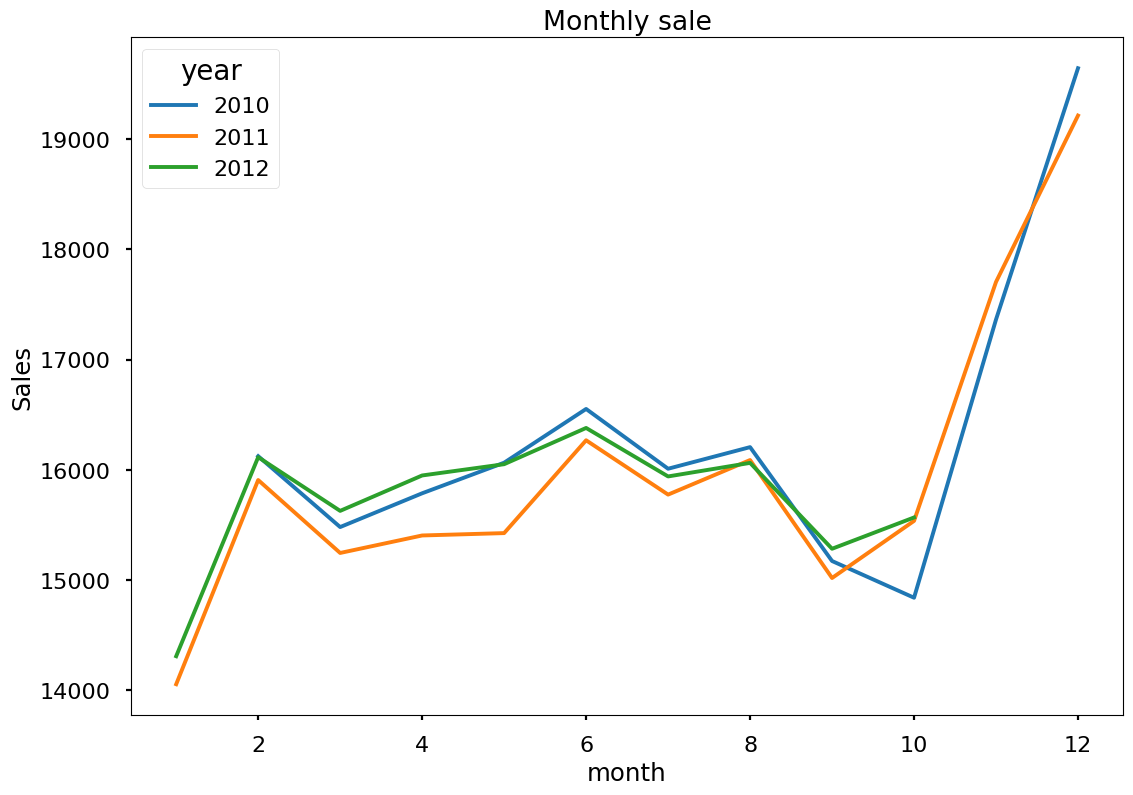

In [128]:
# Monthly sale
plt.figure(figsize=(15,5))
monthly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot()
plt.grid(False)
plt.ylabel('Sales')
plt.title('Monthly sale')
plt.show()

Looking at the graph, it's evident that overall sales were lower in 2011 compared to 2010. When we calculate the average sales, we see that 2010 has higher values. However, it's worth noting that the data for November and December in 2012, which usually have higher sales, is missing. Even though 2012 lacks information for the last two months, its mean sales are close to those of 2010. It's likely that 2012 would take the lead if we had the results for those missing months.

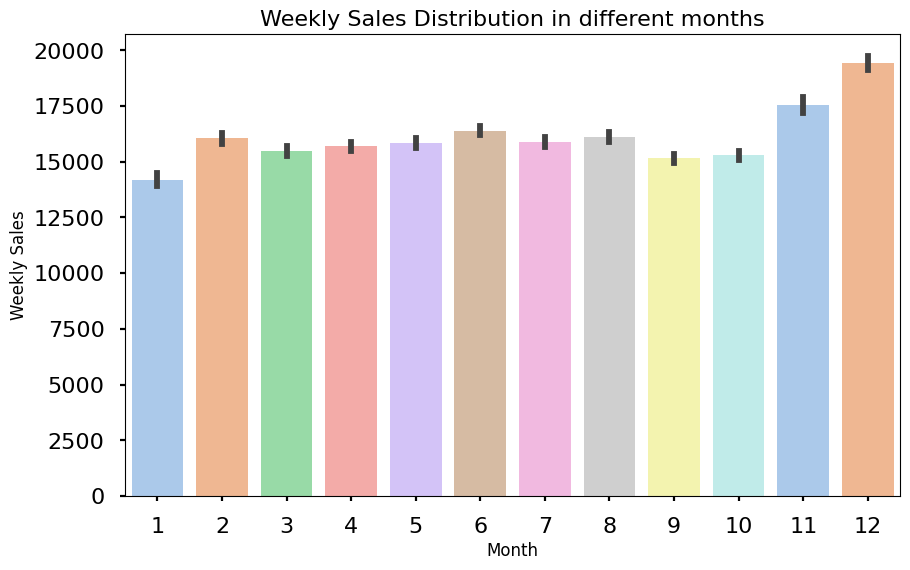

In [129]:
custom_palette = sns.color_palette("pastel")
plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='Weekly_Sales', data=df, palette=custom_palette)
plt.title('Weekly Sales Distribution in different months', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Weekly Sales', fontsize=12)
plt.grid(False)
plt.show()

When we look at the graph above, the best sales are in December and November, as expected. The highest values are belongs to Thankgiving holiday but when we take average it is obvious that December has the best value.

In [130]:
df.groupby('week')['Weekly_Sales'].mean().sort_values(ascending=False).head()

week
51    26454.164116
47    22269.601768
50    20478.421134
49    18731.794840
22    16856.650245
Name: Weekly_Sales, dtype: float64

<Figure size 1500x500 with 0 Axes>

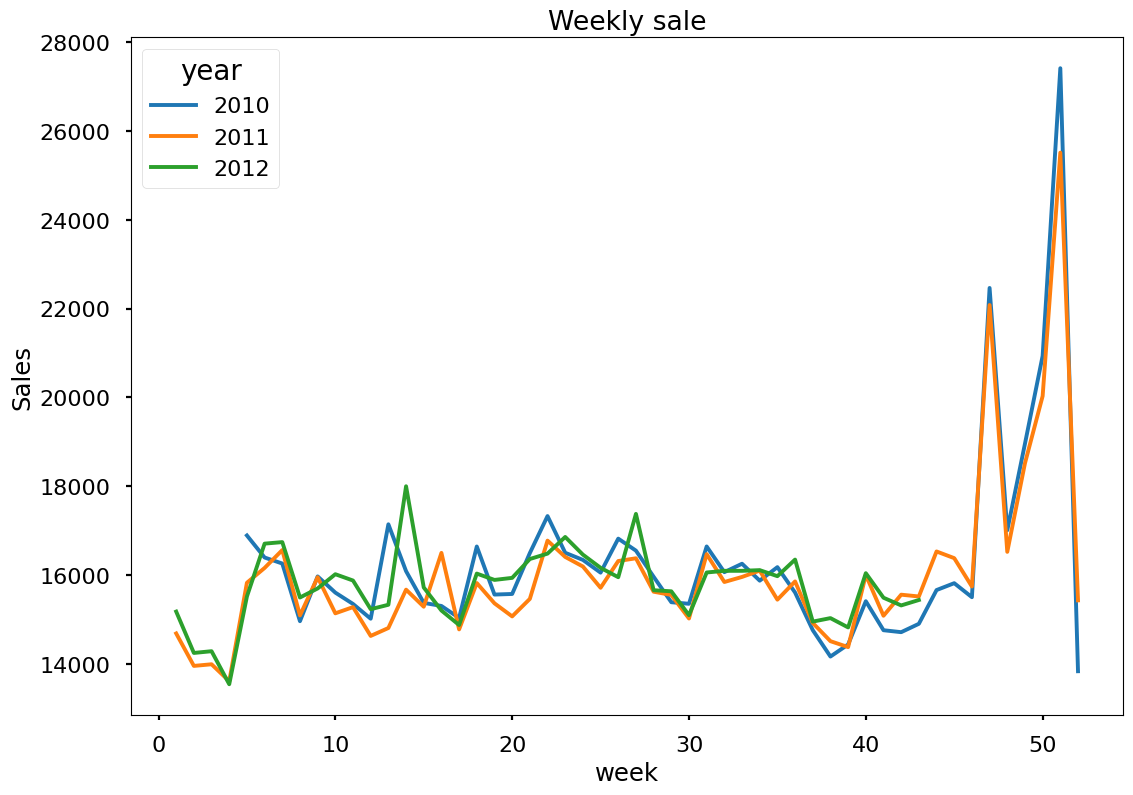

In [131]:
plt.figure(figsize=(15,5))
weekly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()
plt.grid(False)
plt.title('Weekly sale')
plt.ylabel('Sales')
plt.show()

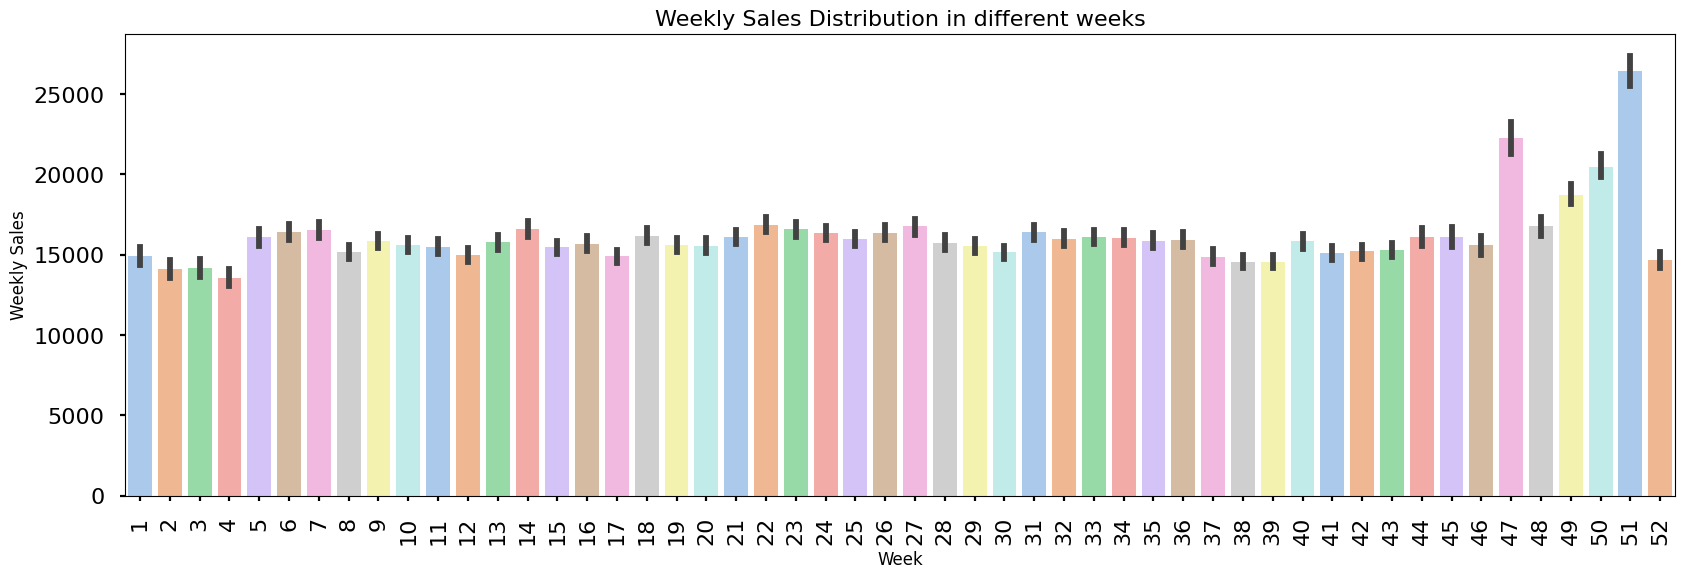

In [132]:
custom_palette = sns.color_palette("pastel")
plt.figure(figsize=(20, 6))
sns.barplot(x='week', y='Weekly_Sales', data=df, palette=custom_palette)
plt.title('Weekly Sales Distribution in different weeks', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.xticks(rotation=90)
plt.ylabel('Weekly Sales', fontsize=12)
plt.grid(False)
plt.show()

From graphs, it is seen that 51th week and 47th weeks have significantly higher averages as Christmas, Thankgiving and Black Friday effects.

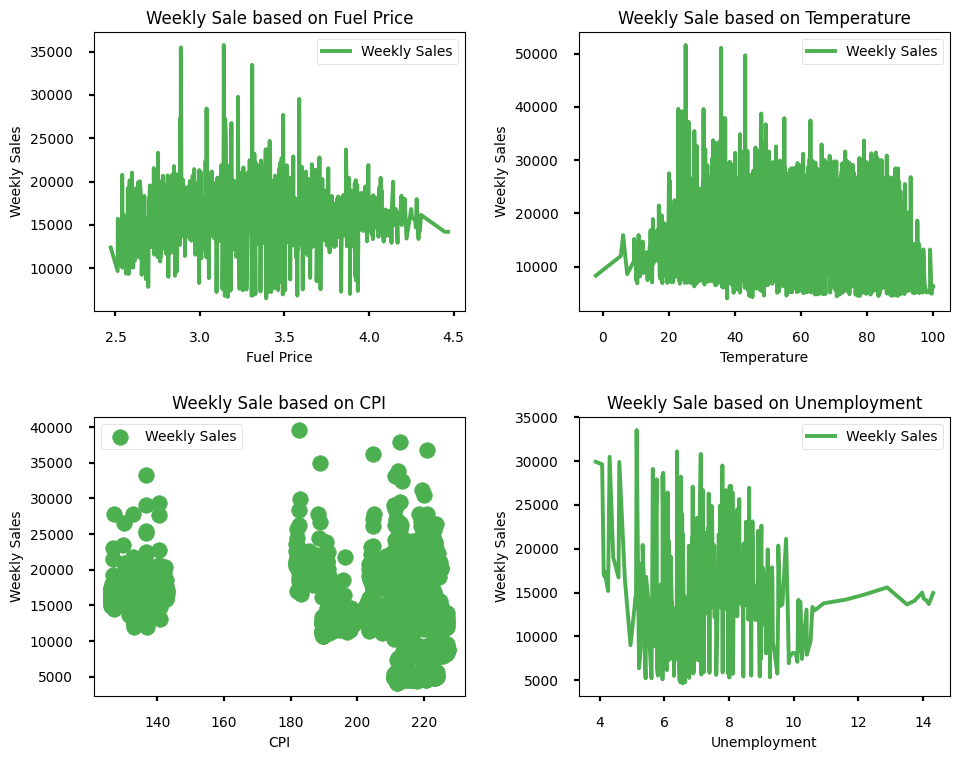

In [133]:
# Fuel Price, CPI , Unemployment , Temperature Effects
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot 1 - Weekly sale based on Fuel Price
fuel_price = pd.pivot_table(df, values="Weekly_Sales", index="Fuel_Price")
fuel_price.plot(ax=axes[0, 0], color='#4CAF50')
axes[0, 0].grid(False)
axes[0, 0].set_title('Weekly Sale based on Fuel Price', fontsize=12)
axes[0, 0].set_ylabel('Weekly Sales' , fontsize=10)
axes[0, 0].set_xlabel('Fuel Price' , fontsize=10)
axes[0, 0].tick_params(axis='both', labelsize=10)
axes[0, 0].legend(['Weekly Sales'], fontsize=10)


# Plot 2 - Weekly sale based on Temperature
temperature = pd.pivot_table(df, values="Weekly_Sales", index="Temperature")
temperature.plot(ax=axes[0, 1], color='#4CAF50')
axes[0, 1].grid(False)
axes[0, 1].set_title('Weekly Sale based on Temperature', fontsize=12)
axes[0, 1].set_ylabel('Weekly Sales', fontsize=10)
axes[0, 1].set_xlabel('Temperature' , fontsize=10)
axes[0, 1].tick_params(axis='both', labelsize=10)
axes[0, 1].legend(['Weekly Sales'], fontsize=10)


# Plot 3 - Weekly sale based on CPI
'''cpi = pd.pivot_table(df, values="Weekly_Sales", index="CPI")
cpi.plot(ax=axes[1, 0], color='#4CAF50')
axes[1, 0].grid(False)
axes[1, 0].set_title('Weekly Sale based on CPI', fontsize=12)
axes[1, 0].set_ylabel('Weekly Sales', fontsize=10)
axes[1, 0].set_xlabel('CPI' , fontsize=10)
axes[1, 0].tick_params(axis='both', labelsize=10)
axes[1, 0].legend(['Weekly Sales'], fontsize=10)'''
# to mask the line when there is a gap
cpi = pd.pivot_table(df, values="Weekly_Sales", index="CPI")
axes[1, 0].scatter(cpi.index, cpi["Weekly_Sales"], color='#4CAF50', label='Weekly Sales', marker='o')
axes[1, 0].grid(False)
axes[1, 0].set_title('Weekly Sale based on CPI', fontsize=12)
axes[1, 0].set_ylabel('Weekly Sales', fontsize=10)
axes[1, 0].set_xlabel('CPI', fontsize=10)
axes[1, 0].tick_params(axis='both', labelsize=10)
axes[1, 0].legend(['Weekly Sales'], fontsize=10)



# Plot 4 - Weekly sale based on Unemployment
unemployment = pd.pivot_table(df, values="Weekly_Sales", index="Unemployment")
unemployment.plot(ax=axes[1, 1], color='#4CAF50')
axes[1, 1].grid(False)
axes[1, 1].set_title('Weekly Sale based on Unemployment', fontsize=12)
axes[1, 1].set_ylabel('Weekly Sales', fontsize=10 )
axes[1, 1].set_xlabel('Unemployment' , fontsize=10)
axes[1, 1].tick_params(axis='both', labelsize=10)
axes[1, 1].legend(['Weekly Sales'], fontsize=10)


# Adjust layout
plt.tight_layout()

plt.show()


Looking at the graphs, there doesn't seem to be any clear patterns between CPI, temperature, unemployment rate, or fuel price and weekly sales. Additionally, there's a data gap for CPI values between 140 and 180.

In [134]:
df.to_csv('clean_data.csv')

## ----------------------------------------------ML Part----------------------------------------------

#### Privious Observations:
- From the data, there are 45 stores and 81 departments, and not all stores have the same departments. Although department 72 shows higher weekly sales values, on average, department 92 performs the best. This suggests that some departments have higher values seasonally, like during Thanksgiving. Notably, the top 5 sales in the data all belong to the 72nd department during Thanksgiving.

- While stores 10 and 35 occasionally have higher weekly sales, on average, stores 20 and 4 rank first and second. This indicates that certain areas experience higher seasonal sales. Stores are categorized into types A, B, and C based on their sizes. Nearly half of the stores, mostly larger than 150,000, fall into category A. Sales vary among store types.

- As expected, holiday average sales surpass those on normal dates. Thanksgiving, among other holidays, has the highest sales, as designated by Walmart.

- In terms of years, 2010 shows higher sales than 2011 and 2012. However, the absence of November and December sales data for 2012 might impact its ranking. Even without the highest sales months, 2012 is not significantly less than 2010. After adding the last two months, it could potentially take the lead.

- Weeks 51 and 47 have notably higher values, with weeks 50 to 48 following closely. The 5th highest sales occur in the 22nd week of the year, towards the end of May when schools are closed. This indicates that Christmas, Thanksgiving, and Black Friday are crucial sales periods. Interestingly, the 5th important time is the end of May, suggesting people prepare for holidays during this time.

- January sales are significantly lower than other months, likely influenced by the high sales during November and December. After two strong sales months, people tend to spend less in January.

- Lastly, CPI, temperature, unemployment rate, and fuel price show no clear pattern in relation to weekly sales.

#### Random Forest
To find simple baseline model, I will use RandomForestRegressor
Our metric for this project is weighted mean absolute error (WMAE):

![title](WMAE.png)

In [135]:
# Load the data
df = pd.read_csv('./clean_data.csv')
df.drop(columns=['Unnamed: 0'],inplace=True)
df['Date'] = pd.to_datetime(df['Date']) # changing datetime to divide if needs

In [136]:
# Data preparation
df_encoded = df.copy()
 # changing A,B,C to 1-2-3
type_group = {'A':1, 'B': 2, 'C': 3} 
df_encoded['Type'] = df_encoded['Type'].replace(type_group)
# changing T,F to 0-1
df_encoded['Super_Bowl'] = df_encoded['Super_Bowl'].astype(bool).astype(int)
df_encoded['Thanksgiving'] = df_encoded['Thanksgiving'].astype(bool).astype(int)
df_encoded['Labor_Day'] = df_encoded['Labor_Day'].astype(bool).astype(int)
df_encoded['Christmas'] = df_encoded['Christmas'].astype(bool).astype(int)
df_encoded['IsHoliday'] = df_encoded['IsHoliday'].astype(bool).astype(int)
df_new = df_encoded.copy()

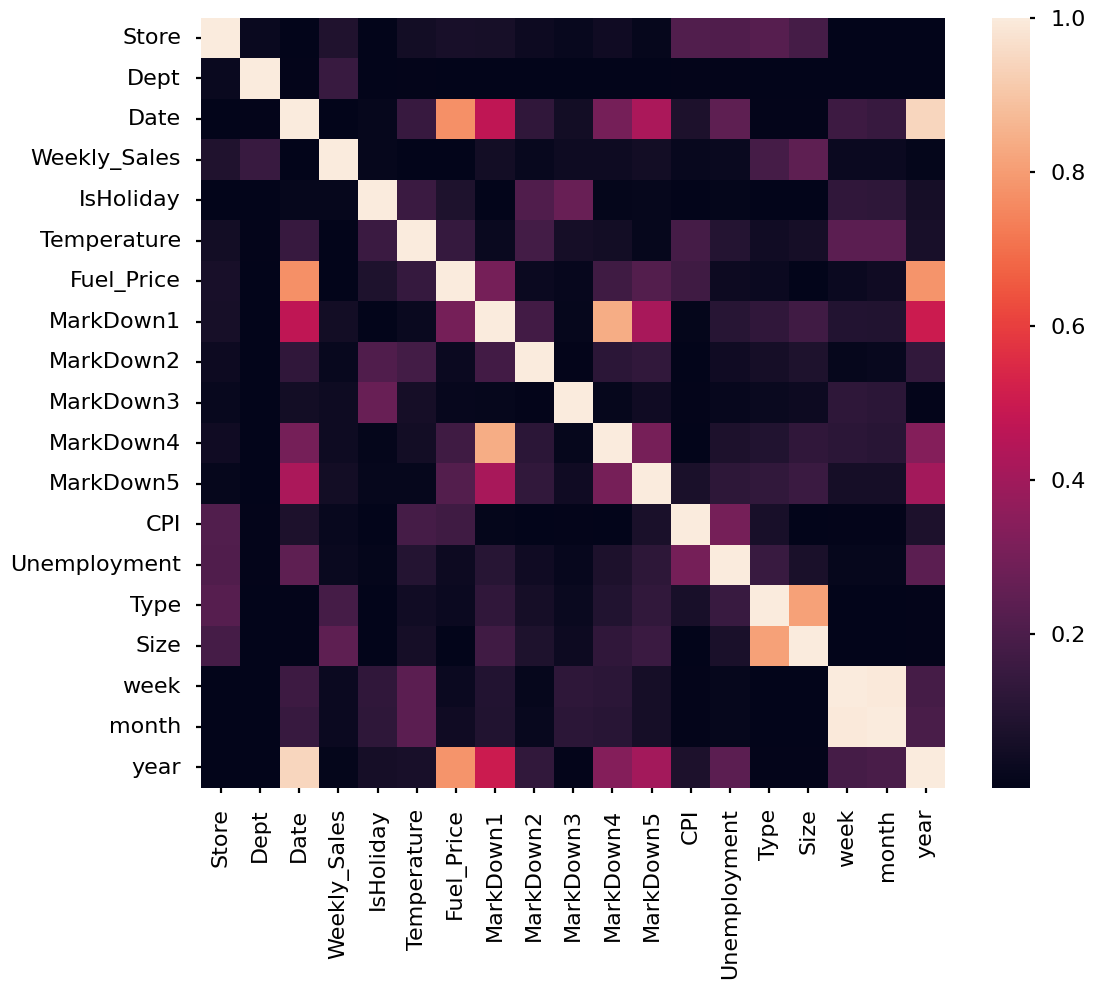

In [137]:
# Correlation between features
drop_col = ['Super_Bowl','Labor_Day','Thanksgiving','Christmas']
df_new.drop(drop_col, axis=1, inplace=True)
plt.figure(figsize = (12,10))
sns.heatmap(df_new.corr().abs())
plt.show()

Temperature, unemployment, CPI have no significant effect on weekly sales, so I will drop them. Also, Markdown 4 and 5 highly correlated with Markdown 1. So, I will drop them also. It can create multicollinearity problem, maybe. So, first I will try without them.

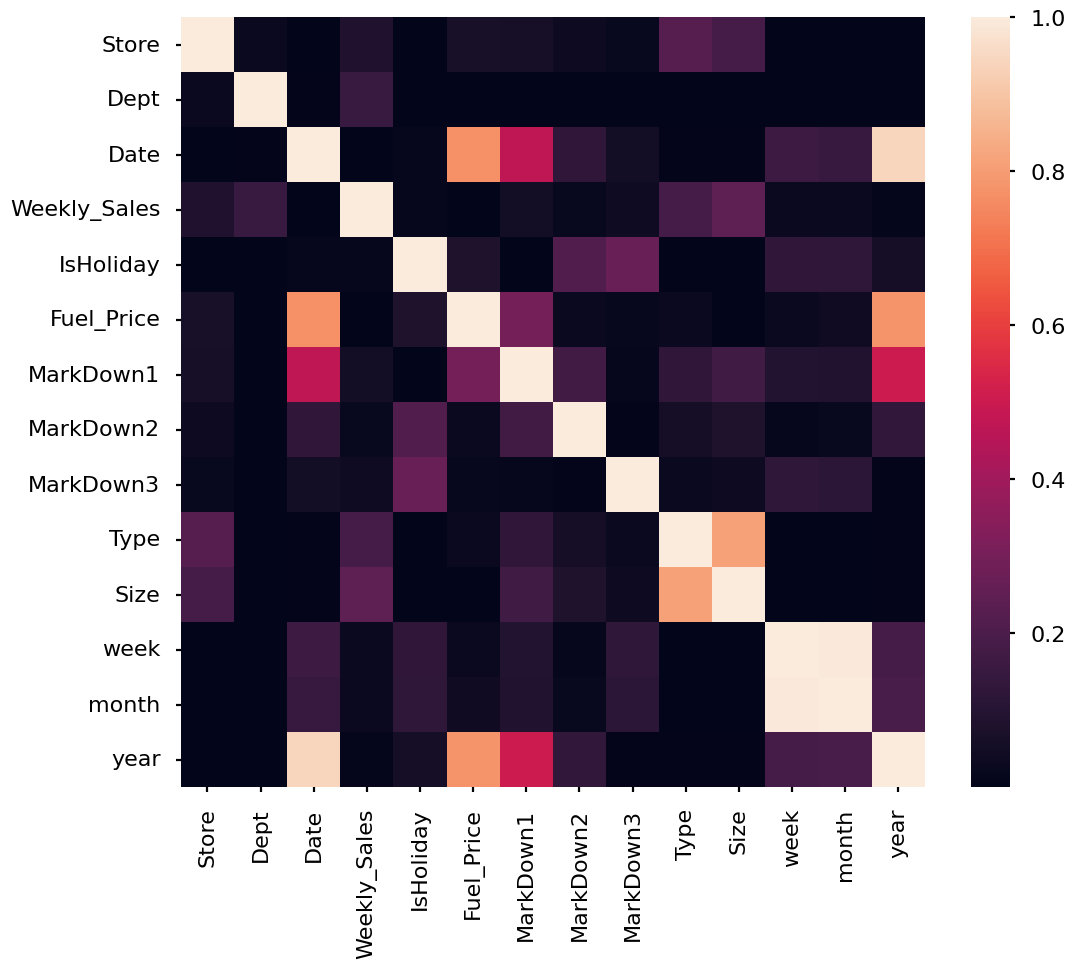

In [138]:
drop_col = ['Temperature','MarkDown4','MarkDown5','CPI','Unemployment']
df_new.drop(drop_col, axis=1, inplace=True) # dropping columns
plt.figure(figsize = (12,10))
sns.heatmap(df_new.corr().abs())    # To see the correlations without dropping columns
plt.show()

Size and type are highly correlated with weekly sales. Also, department and store are correlated with sales.

In [139]:
df_new = df_new.sort_values(by='Date', ascending=True)

In [140]:
# Train-Test Splits
train_data = df_new[:int(0.7*(len(df_new)))] # taking train part
test_data = df_new[int(0.7*(len(df_new))):] # taking test part

target = "Weekly_Sales"
used_cols = [c for c in df_new.columns.to_list() if c not in [target]] # all columns except weekly sales

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

In [141]:
X = df_new[used_cols]

In [142]:
 # dropping date from train
X_train = X_train.drop(['Date'], axis=1)
 # dropping date from test
X_test = X_test.drop(['Date'], axis=1)

In [143]:
# Metric Definition
def wmae_test(test, pred): # WMAE for test 
    weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

### Random Forest Regressor

In [144]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

#making pipe tp use scaler and regressor together
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train, y_train)

# predictions on train set
y_pred = pipe.predict(X_train)

# predictions on test set
y_pred_test = pipe.predict(X_test)
wmae_test(y_test, y_pred_test)

5768.913872812056

###### For the first trial, my weighted error is around 5768.

Feature ranking:
1. feature 1 (0.732627)
2. feature 8 (0.104991)
3. feature 0 (0.054432)
4. feature 7 (0.042979)
5. feature 9 (0.021353)
6. feature 3 (0.018550)
7. feature 10 (0.009611)
8. feature 6 (0.005946)
9. feature 4 (0.003181)
10. feature 5 (0.002630)
11. feature 2 (0.002238)
12. feature 11 (0.001462)


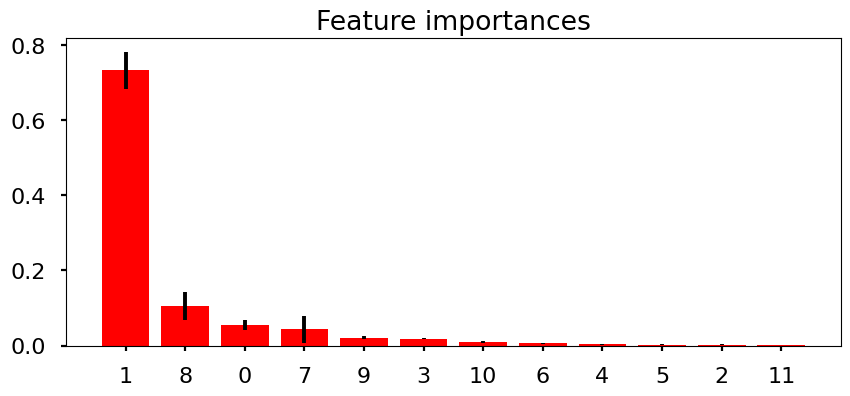

In [145]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

num_features = min(X.shape[1], len(indices))

for f in range(num_features):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure(figsize=(10, 4))
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices][:num_features],
       color="r", yerr=std[indices][:num_features], align="center")
plt.xticks(range(num_features), indices[:num_features])
plt.xlim([-1, num_features])
plt.grid(False)
plt.show()


After looking feature importance, I dropped least important 3-4 features and tried the model. I found the best result when I dropped month column which is highly correlated with week.

In [146]:
# Dropping month
X1_train = X_train.drop(['month'], axis=1)
X1_test = X_test.drop(['month'], axis=1)

In [147]:
# Model Again without Month
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X1_train, y_train)

# predictions on train set
y_pred = pipe.predict(X1_train)

# predictions on test set
y_pred_test = pipe.predict(X1_test)

In [148]:
wmae_test(y_test, y_pred_test)

5309.293352970448

It gives better results than baseline.

In [149]:
# Model with Whole Data
# Now, I want to make sure that my model will learn from the columns which I dropped or not. 
# So, I will apply my model to whole encoded data again.
# splitting train-test to whole dataset
train_data_enc = df_encoded[:int(0.7*(len(df_encoded)))]
test_data_enc = df_encoded[int(0.7*(len(df_encoded))):]

target = "Weekly_Sales"
used_cols1 = [c for c in df_encoded.columns.to_list() if c not in [target]] # all columns except price

X_train_enc = train_data_enc[used_cols1]
X_test_enc = test_data_enc[used_cols1]
y_train_enc = train_data_enc[target]
y_test_enc = test_data_enc[target]

In [150]:
# to get together train,test splits
X_enc = df_encoded[used_cols1] 
# dropping date column for whole X
X_enc = X_enc.drop(['Date'], axis=1)
# dropping date from train and test
X_train_enc = X_train_enc.drop(['Date'], axis=1) 
X_test_enc= X_test_enc.drop(['Date'], axis=1)

In [151]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc, y_train_enc)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc)

In [152]:
wmae_test(y_test_enc, y_pred_test_enc)

2560.383223530276

We found better results for whole data, it means our model can learn from columns which I dropped before.

Feature ranking:
1. feature 1 (0.743067)
2. feature 13 (0.073267)
3. feature 12 (0.045187)
4. feature 0 (0.031574)
5. feature 10 (0.030197)
6. feature 11 (0.016318)
7. feature 18 (0.012174)
8. feature 3 (0.011081)
9. feature 4 (0.010190)
10. feature 19 (0.005183)
11. feature 7 (0.004519)
12. feature 9 (0.003980)
13. feature 5 (0.003492)
14. feature 8 (0.003457)
15. feature 6 (0.002405)
16. feature 20 (0.001097)
17. feature 2 (0.000892)
18. feature 16 (0.000885)
19. feature 17 (0.000495)
20. feature 14 (0.000274)
21. feature 15 (0.000266)


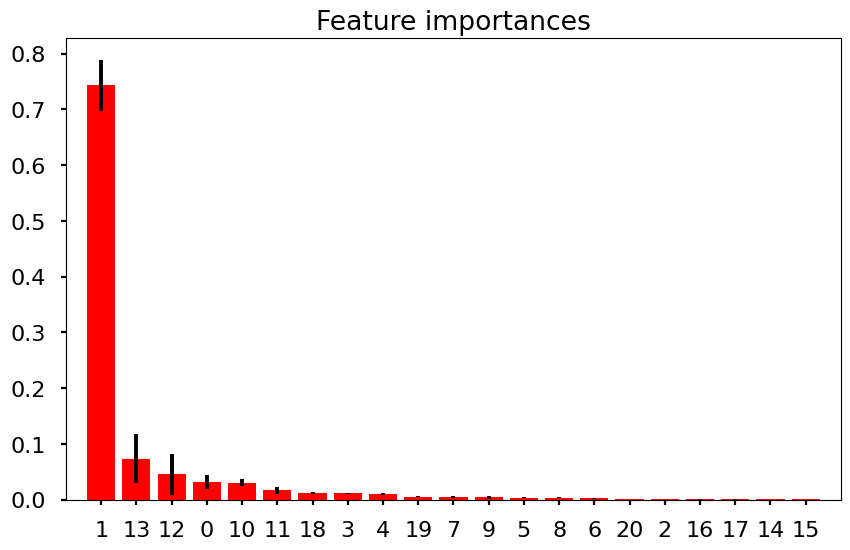

In [153]:
# Feature Importance for Whole Encoded Dataset
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X_enc.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_enc.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_enc.shape[1]), indices)
plt.xlim([-1, X_enc.shape[1]])
plt.grid(False)
plt.show()

According to feature importance, I dropped some columns from whole set and try my model again.

In [154]:
# taking copy of encoded data to keep it without change
df_encoded_new = df_encoded.copy()
df_encoded_new.drop(drop_col, axis=1, inplace=True)

In [155]:
#train-test splitting
train_data_enc_new = df_encoded_new[:int(0.7*(len(df_encoded_new)))]
test_data_enc_new = df_encoded_new[int(0.7*(len(df_encoded_new))):]

target = "Weekly_Sales"
used_cols2 = [c for c in df_encoded_new.columns.to_list() if c not in [target]] # all columns except price

X_train_enc1 = train_data_enc_new[used_cols2]
X_test_enc1 = test_data_enc_new[used_cols2]
y_train_enc1 = train_data_enc_new[target]
y_test_enc1 = test_data_enc_new[target]

#droping date from train-test
X_train_enc1 = X_train_enc1.drop(['Date'], axis=1)
X_test_enc1= X_test_enc1.drop(['Date'], axis=1)

In [156]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=40,
                           max_features = 'log2',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc1, y_train_enc1)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc1)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc1)

In [157]:
pipe.score(X_test_enc1,y_test_enc1)

0.7432866030232561

In [158]:
wmae_test(y_test_enc1, y_pred_test_enc)

1855.9068589512615

I found best results with doing feature selection from whole encoded dataset.

In [159]:
# Model with Dropping Month Column
# With the same dateset before, I try to model again without month column.
df_encoded_new1 = df_encoded.copy()
df_encoded_new1.drop(drop_col, axis=1, inplace=True)

In [160]:
df_encoded_new1 = df_encoded_new1.drop(['Date'], axis=1)
df_encoded_new1 = df_encoded_new1.drop(['month'], axis=1)

In [161]:
#train-test split
train_data_enc_new1 = df_encoded_new1[:int(0.7*(len(df_encoded_new1)))]
test_data_enc_new1 = df_encoded_new1[int(0.7*(len(df_encoded_new1))):]

target = "Weekly_Sales"
used_cols3 = [c for c in df_encoded_new1.columns.to_list() if c not in [target]] # all columns except price

X_train_enc2 = train_data_enc_new1[used_cols3]
X_test_enc2 = test_data_enc_new1[used_cols3]
y_train_enc2 = train_data_enc_new1[target]
y_test_enc2 = test_data_enc_new1[target]

In [162]:
#modeling part
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc2, y_train_enc2)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc2)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc2)

In [163]:
pipe.score(X_test_enc2,y_test_enc2)

0.7040521864786917

In [164]:
wmae_test(y_test_enc2, y_pred_test_enc)

2100.0600120168897

It did not give better results than before.

In [165]:
# Initialize an empty DataFrame or load it from your data source
df_results = pd.DataFrame(columns=["Model", "Info", "WMAE"])

# Create a new row as a dictionary
new_row = {
    "Model": 'RandomForestRegressor',
    "Info": 'w/out divided holiday columns',
    'WMAE': 5768
}

# Concatenate the new row to the DataFrame
df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)

In [166]:
# Create a new DataFrame with the desired rows
new_rows = pd.DataFrame({
    "Model": ['RandomForestRegressor', 'RandomForestRegressor', 'RandomForestRegressor', 'RandomForestRegressor'],
    "Info": ['w/out month column', 'whole data', 'whole data with feature selection', 'whole data with feature selection w/out month'],
    "WMAE": [5309, 2560, 1855, 2100]
})

# Concatenate the new rows to the existing DataFrame
df_results = pd.concat([df_results, new_rows], ignore_index=True)


In [167]:
df_results

,Model,Info,WMAE
0,RandomForestRegressor,w/out divided holiday columns,5768
1,RandomForestRegressor,w/out month column,5309
2,RandomForestRegressor,whole data,2560
3,RandomForestRegressor,whole data with feature selection,1855
4,RandomForestRegressor,whole data with feature selection w/out month,2100


The best results belongs to whole data set with feature selection. Now, I will try time series models.

#### Time Series Models

In [168]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010


In [169]:
# changing data to datetime for decomposing
df["Date"] = pd.to_datetime(df["Date"]) 
# seting date as index
df.set_index('Date', inplace=True) 

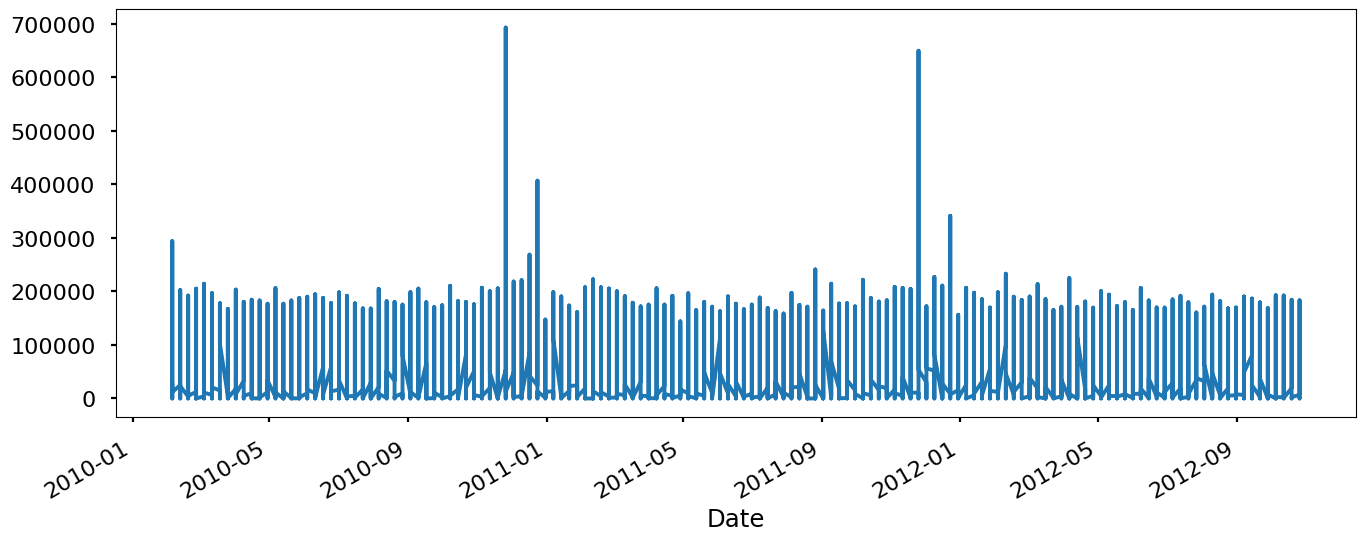

In [170]:
plt.figure(figsize=(16,6))
df['Weekly_Sales'].plot()
plt.grid(False)
plt.show()

In [171]:
# resample data as weekly
df_week = df.resample('W').mean(numeric_only=True)

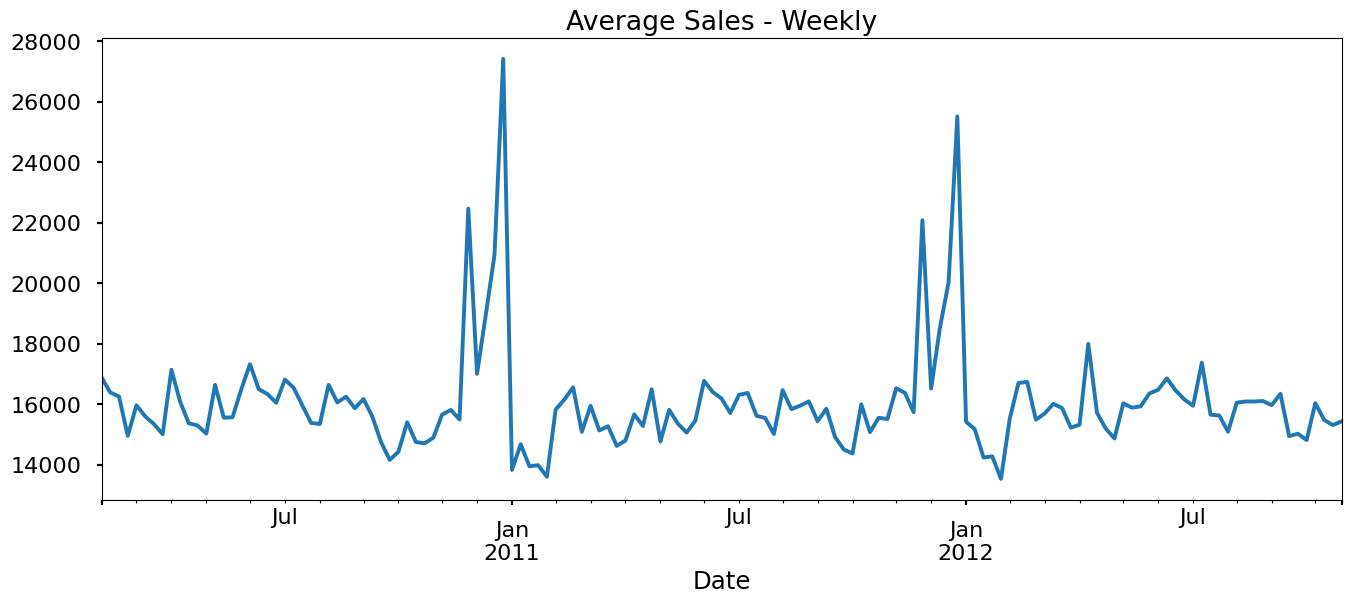

In [172]:
plt.figure(figsize=(16,6))
df_week['Weekly_Sales'].plot()
plt.title('Average Sales - Weekly')
plt.grid(False)
plt.show()

With the collecting data as weekly, I can see average sales clearly. To see monthly pattern , I resampled my data to monthly also.

In [173]:
# To Observe 2-weeks Rolling Mean and Std

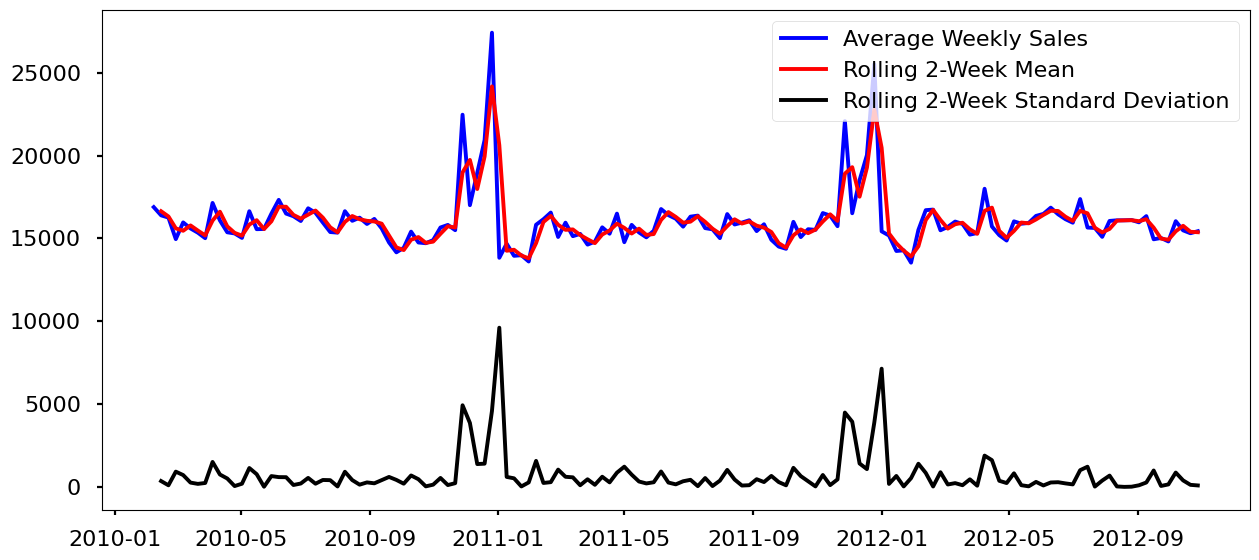

In [174]:
# finding 2-weeks rolling mean and std
roll_mean = df_week['Weekly_Sales'].rolling(window=2, center=False).mean()
roll_std = df_week['Weekly_Sales'].rolling(window=2, center=False).std()
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week['Weekly_Sales'], color='blue',label='Average Weekly Sales')
ax.plot(roll_mean, color='red', label='Rolling 2-Week Mean')
ax.plot(roll_std, color='black', label='Rolling 2-Week Standard Deviation')
ax.legend()
plt.grid(False)
fig.tight_layout()

In [175]:
# Adfuller Test to Make Sure
adfuller(df_week['Weekly_Sales'])

(-5.927107223737573,
 2.4290492082042356e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 2261.596421168073)

From test and my observations my data is not stationary. So, I will try to find more stationary version of it.

In [176]:
# Train - Test Split of Weekly Data
# To take train-test splits continuosly, I split them manually, not random.
train_data = df_week[:int(0.7*(len(df_week)))] 
test_data = df_week[int(0.7*(len(df_week))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)

Train: (100, 21)
Test: (43, 21)


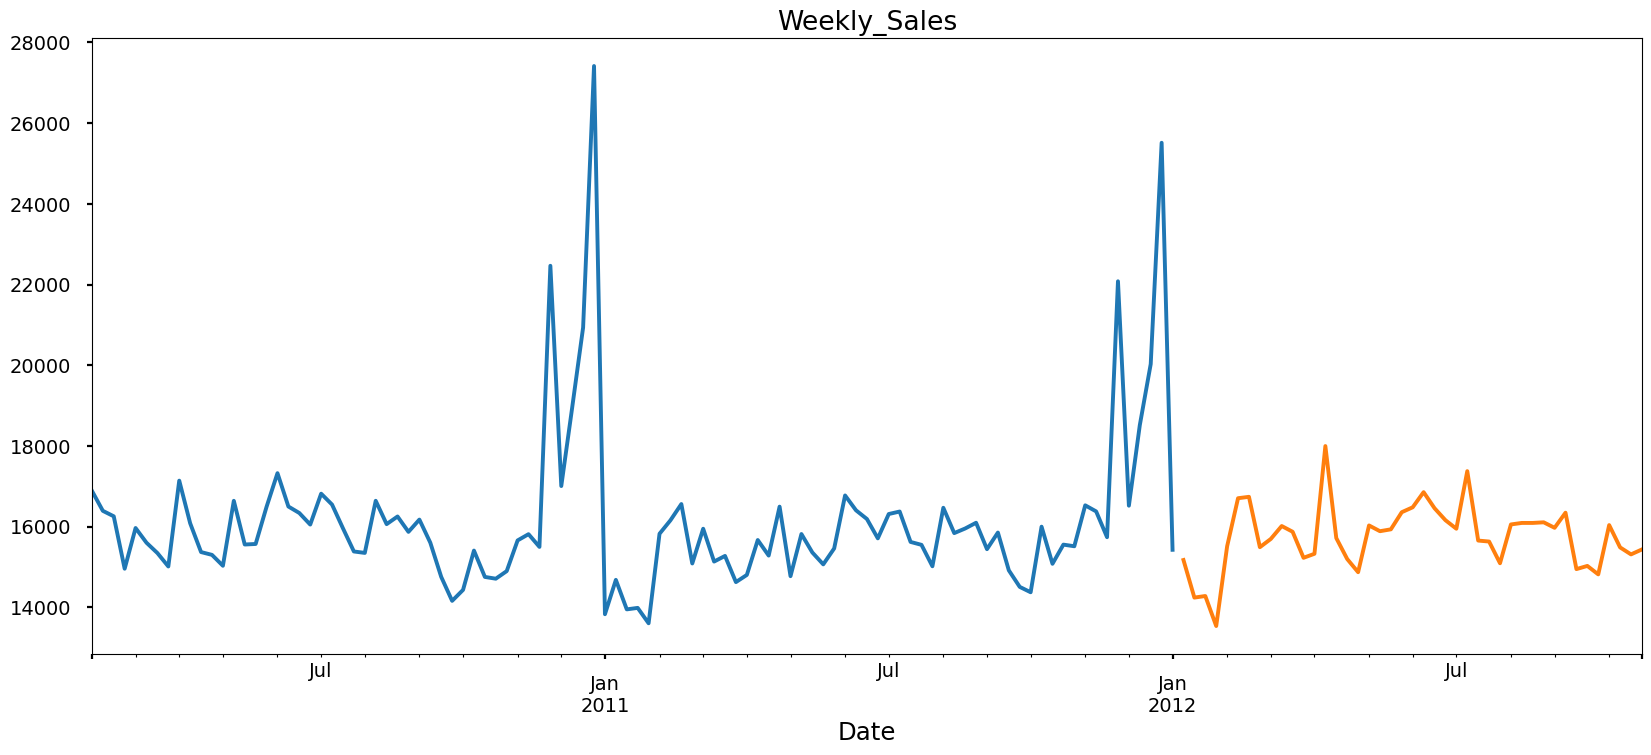

In [177]:
target = "Weekly_Sales"
used_cols = [c for c in df_week.columns.to_list() if c not in [target]] # all columns except price

# assigning train-test X-y values

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]
train_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.grid(False)
plt.show()

Blue line represents my train data, yellow is test data.

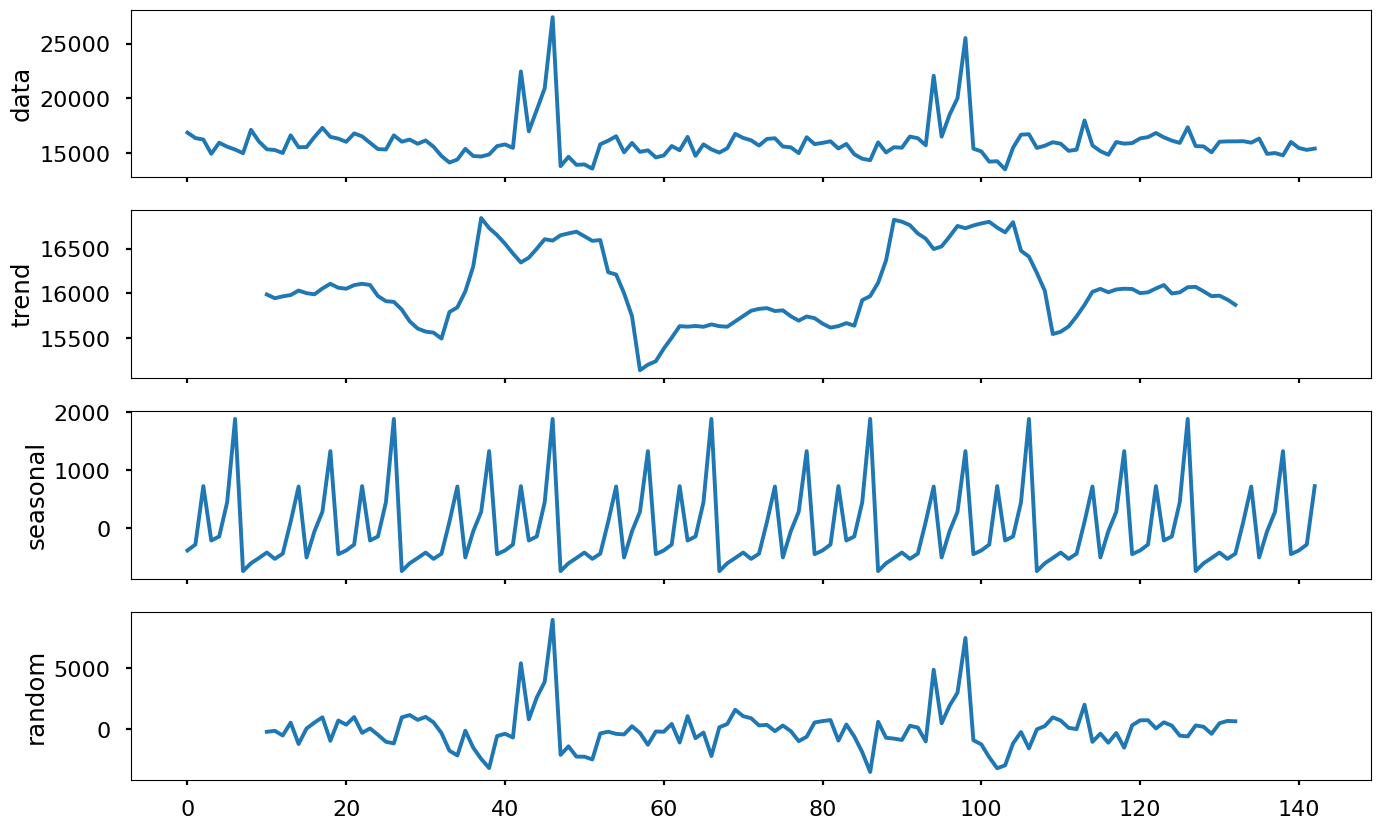

In [178]:
# Decomposing Weekly Data to Observe Seasonality
decomposed = decompose(df_week['Weekly_Sales'].values, 'additive', m=20) #decomposing of weekly data 
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

From the graphs above, every 20 step seasonality converges to beginning point. This helps me to tune my model.

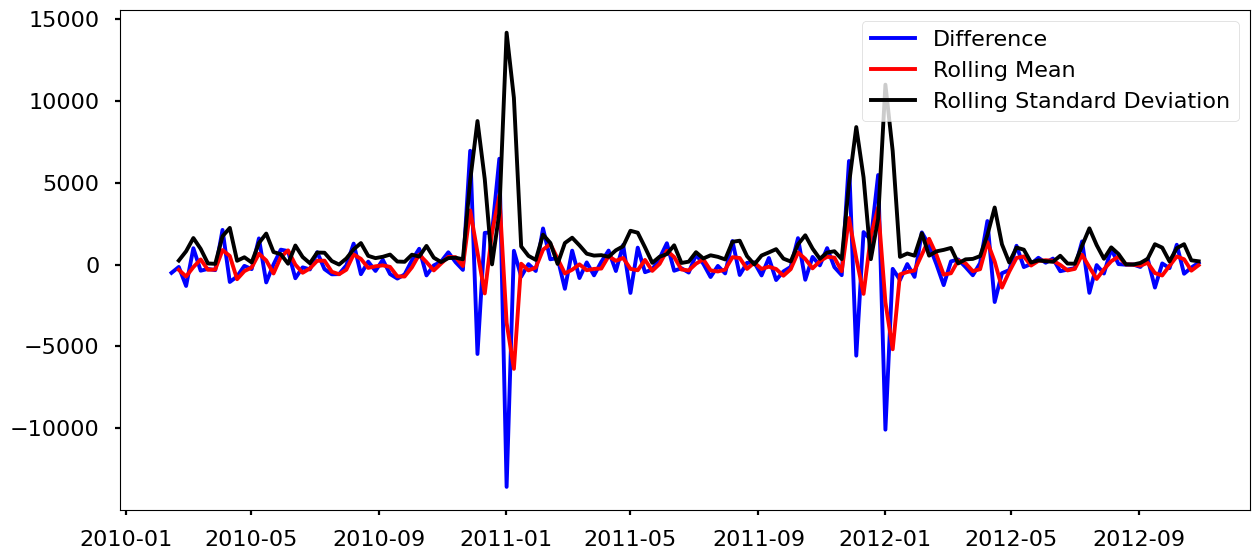

In [179]:
# Trying To Make Data More Stationary
# 1. Difference
df_week_diff = df_week['Weekly_Sales'].diff().dropna() #creating difference values
# taking mean and std of differenced data
diff_roll_mean = df_week_diff.rolling(window=2, center=False).mean()
diff_roll_std = df_week_diff.rolling(window=2, center=False).std()
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_diff, color='blue',label='Difference')
ax.plot(diff_roll_mean, color='red', label='Rolling Mean')
ax.plot(diff_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
plt.grid(False)
fig.tight_layout()

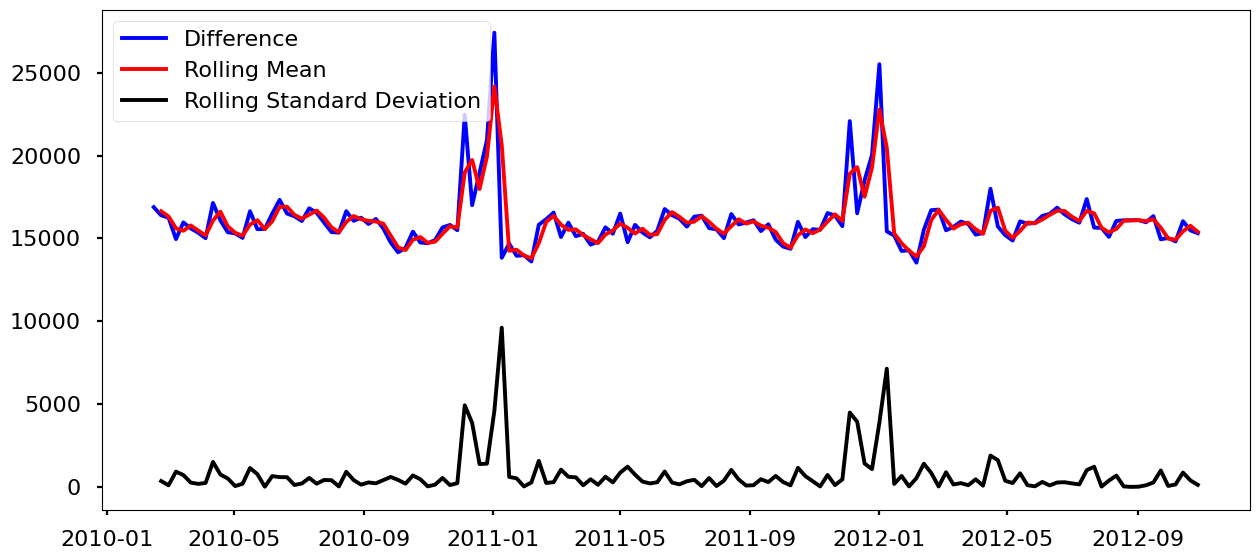

In [180]:
# 2.Shift
df_week_lag = df_week['Weekly_Sales'].shift().dropna() #shifting the data 
lag_roll_mean = df_week_lag.rolling(window=2, center=False).mean() 
lag_roll_std = df_week_lag.rolling(window=2, center=False).std()
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_lag, color='blue',label='Difference')
ax.plot(lag_roll_mean, color='red', label='Rolling Mean')
ax.plot(lag_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
plt.grid(False)
fig.tight_layout()

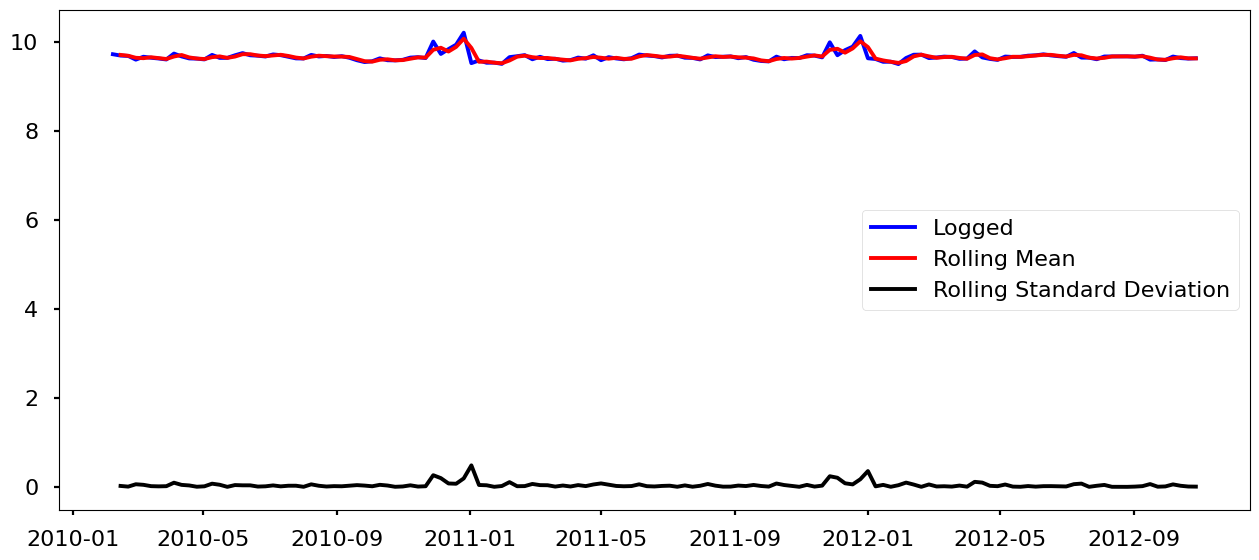

In [181]:
# 3.Log
logged_week = np.log1p(df_week['Weekly_Sales']).dropna() #taking log of data
log_roll_mean = logged_week.rolling(window=2, center=False).mean()
log_roll_std = logged_week.rolling(window=2, center=False).std()
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(logged_week, color='blue',label='Logged')
ax.plot(log_roll_mean, color='red', label='Rolling Mean')
ax.plot(log_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
plt.grid(False)
fig.tight_layout()

### Auto-ARIMA MODEL

In [182]:
# Train-Test Split
train_data_diff = df_week_diff [:int(0.7*(len(df_week_diff )))]
test_data_diff = df_week_diff [int(0.7*(len(df_week_diff ))):]
# train_data = train_data['Weekly_Sales']
# test_data = test_data['Weekly_Sales']

model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1826.858, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1793.619, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1795.532, Time=0.17 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.051, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1794.966, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1801.215, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1791.045, Tim

ARIMA(maxiter=200, order=(3, 0, 2), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

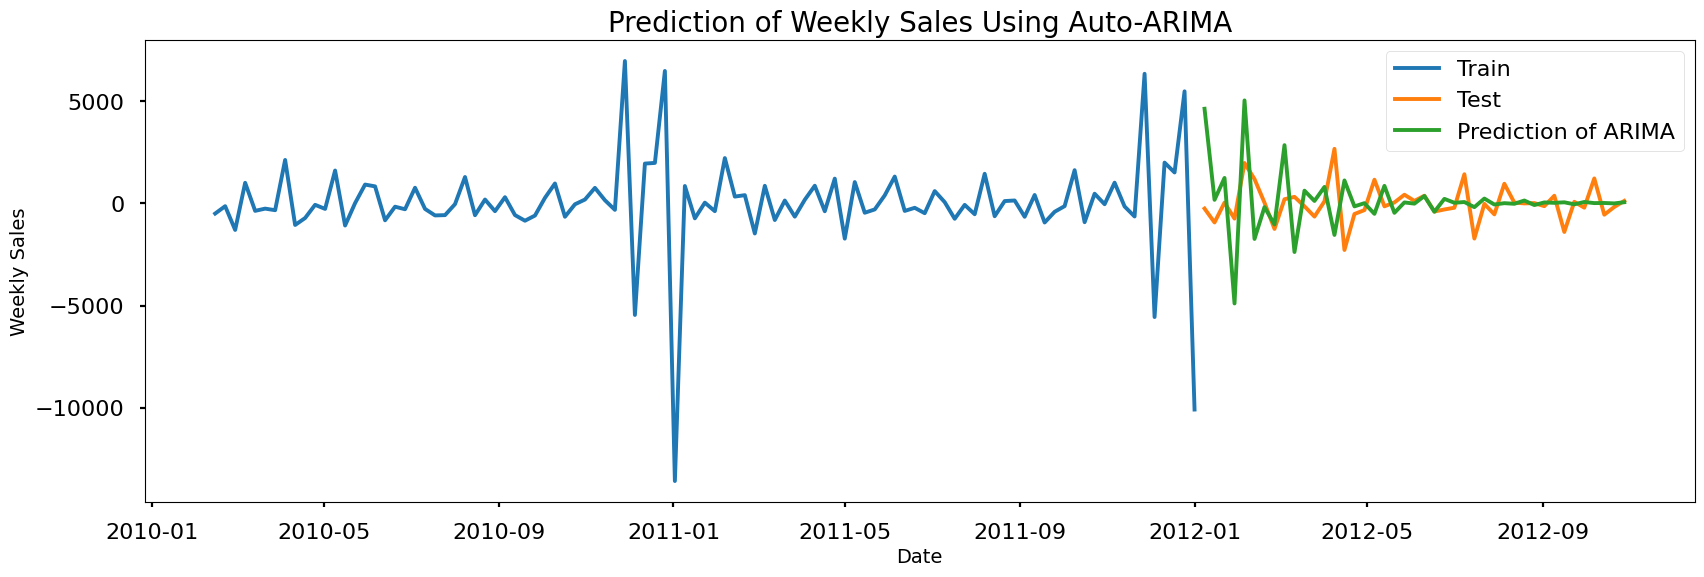

In [183]:
y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.grid(False)
plt.show()

In [187]:
# Metrics
y_true = test_data_diff

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f'Mean Absolute Error (MAE): {mae:.4f}')

# Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error (MSE): {mse:.4f}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Absolute Error (MAE): 1103.6812
Mean Squared Error (MSE): 2827182.1816
Root Mean Squared Error (RMSE): 1681.4227
Mean Absolute Percentage Error (MAPE): nan%


#### Mean Absolute Error (MAE):

If MAE is high, it indicates that, on average, the absolute differences between the predicted and actual values are large. This means the model might be making significant errors.

#### Mean Squared Error (MSE) and Root Mean Squared Error (RMSE):

These metrics penalize larger errors more heavily. If MSE or RMSE is high, it means there are instances where the model's predictions deviate substantially from the actual values.

#### Mean Absolute Percentage Error (MAPE):

If MAPE is high, it suggests that the model's percentage errors (as a proportion of the actual values) are large on average.
MAPE is the mean percentage difference between predicted and actual values.
It is expressed as a percentage and provides a relative measure of accuracy.
MAPE is not defined when the actual values contain zero, which might lead to "nan%" in the output.
For the "nan%" in MAPE, it indicates that there might be some actual values (in y_true) that are zero. MAPE is not defined when the denominator is zero, resulting in "nan". 

#### Based on these metrics and the differences between test data and predicted data in the plot, I decided to try another model.

#### ExponentialSmoothing

I checked suitable Holt-Winters models according tp my data. Exponential Smooting are used when data has trend, and it flattens the trend. The damped trend method adds a damping parameter so, the trend converges to a constant value in the future.

My difference data has some minus and zero values, so I used additive seasonal and trend instead of multiplicative. Seasonal periods are chosen from the decomposed graphs above. For tuning the model with iterations take too much time so, I changed and tried model for different parameters and found the best parameters and fitted them to model.

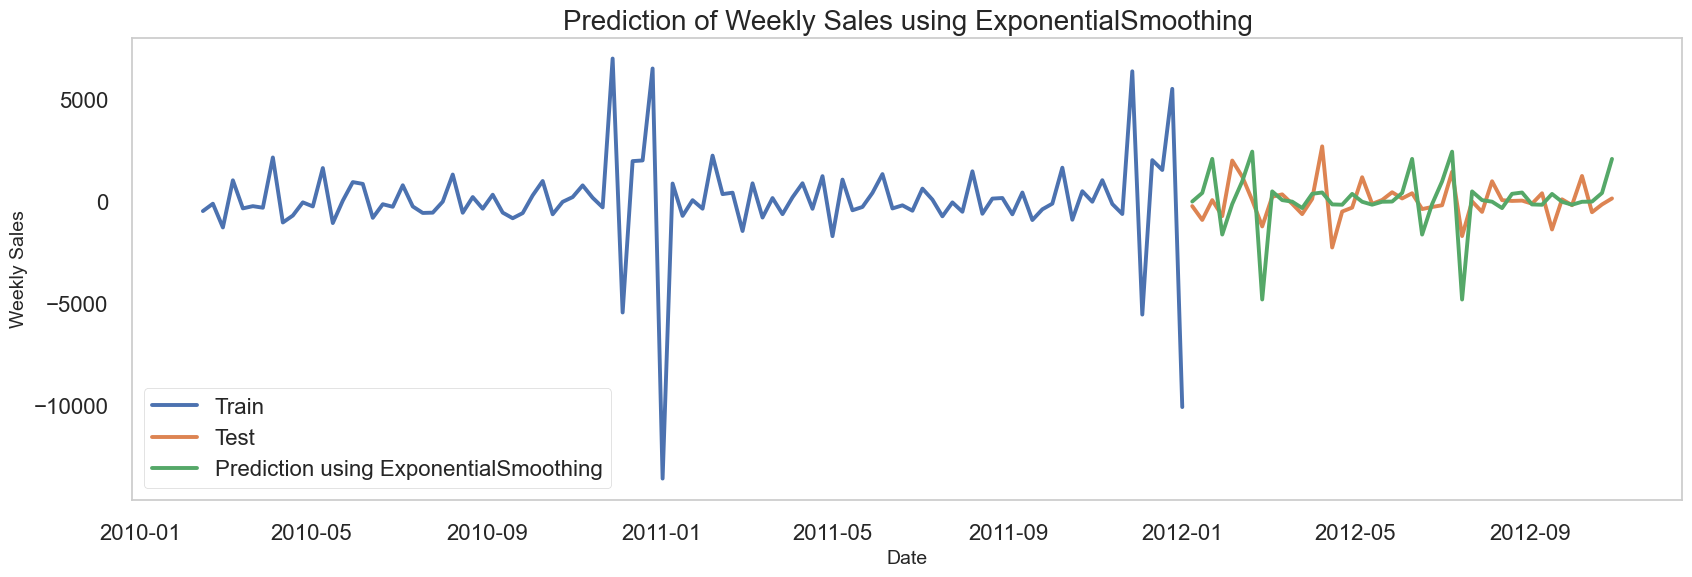

In [309]:
model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit() #Taking additive trend and seasonality.
y_pred = model_holt_winters.forecast(len(test_data_diff))# Predict the test data

#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.grid(False)
plt.show()

In [310]:
wmae_test(test_data_diff, y_pred)

840.6810609666959

At the end, I found best results for my data with Exponential Smoothing Model.

My best result for this project is 840. According to sales amounts this value is roughly around 4-5% error. If we can take our average sales and take percentage of 840 errors, it gives 4-5% roughly.

## Report Summary

Objective:
The primary goal of this  analysis was to predict the weekly sales of Walmart stores by exploring the impact of time based and spacen based factors, with a special focus on the influence of holidays.

#### Key Findings:

- Holiday Impact:

Average weekly sales during holiday weeks, especially Thanksgiving, showed a significant increase compared to non-holiday weeks.
Labor Day did not exhibit a substantial boost in weekly average sales and people tend to purchase Christmas gifts 1-2 weeks before Christmas and such customer behavior is also causing a negative sale in the week of Christmas. 
Thanksgiving demonstrated the most significant positive impact, likely influenced by Christmas gift purchases and Black Friday sales.

- Store Type Effect on Holidays:

Analyzing different store types (A, B, C) during holidays revealed that Type A consistently had the highest average weekly sales across all holiday weeks.
Thanksgiving week, in particular, showed a remarkable difference in sales among store types, with Type A leading.

- Store Size and Sales:

Larger stores generally had higher sales, aligning with expectations.
Type A stores, the largest category, consistently demonstrated the highest sales impact.

- Seasonal and Departmental Patterns:
Seasonal department (Department 72) exhibited higher sales in certain seasons, while, on average, Department 92 performed the best.
Some stores and departments experienced higher seasonal sales, indicating the importance of understanding these patterns.

- Time-Based Trends:

Overall sales were lower in 2011 compared to 2010, with a data gap in November and December 2012.
The analysis suggested that 2012 might surpass 2010 if the missing data for the last two months were available.
Weeks 51 and 47 consistently had notably higher sales, emphasizing the importance of holiday seasons.

### Modeling

Random Forest Regressor produced favorable results, with the best performance achieved using the entire dataset with feature selection.
Weighted Mean Absolute Error (WMAE) values improved through careful feature selection and optimization.

Time Series Models:

Decomposition of weekly sales revealed clear seasonality with a repeating pattern every 20 steps.
Attempts were made to make the data more stationary through differencing, shifting, and taking the log.

#### Conclusion:

In conclusion, our analysis provides valuable insights into the factors influencing weekly sales at Walmart. The impact of holidays, store types, sizes, and seasonal patterns should be considered for effective sales forecasting. The Random Forest Regressor, coupled with feature selection, emerged as a robust model for predictions. Further exploration into time series models and continuous monitoring of sales patterns will enhance the accuracy of future predictions.